### Git versioning

In [1]:
import git  #Requires Gitpython installed, to install do "$ pip install Gitpython" in your terminal
import pkg_resources
openfisca_france_location = pkg_resources.get_distribution('openfisca-france').location
repo = git.Repo(openfisca_france_location)
repo.git.status()

sha = repo.head.object.hexsha

print "---This notebook have been runed with--- \n","Openfisca-france :", repo.head.object.hexsha, '\n' 
print "Commit short SHA:", repo.git.rev_parse(sha, short=4)
print "Branch: ", repo.git.rev_parse('--abbrev-ref', "HEAD") #equivalent to: $git rev-parse --abbrev-ref HEAD
print "Date (y/m/d):", repo.git.show("-s", '--format=%ci', 'HEAD^')[:-5],"\n"  # equivalent to: $git show -s --format=%ci HEAD^

print "Openfisca-core :", git.Repo(pkg_resources.get_distribution('openfisca-core').location).head.object.hexsha, ' Date:', git.Repo(pkg_resources.get_distribution('openfisca-core').location).git.show("-s", '--format=%ci', 'HEAD^')[:-5]
print "Openfisca-france-data :", git.Repo(pkg_resources.get_distribution('openfisca-france-data').location).head.object.hexsha, ' Date:', git.Repo(pkg_resources.get_distribution('openfisca-france-data').location).git.show("-s", '--format=%ci', 'HEAD^')[:-5]
print "OpenFisca-Aggregates :", git.Repo(pkg_resources.get_distribution('OpenFisca-Aggregates').location).head.object.hexsha, ' Date:', git.Repo(pkg_resources.get_distribution('OpenFisca-Aggregates').location).git.show("-s", '--format=%ci', 'HEAD^')[:-5]
print "OpenFisca-Survey-Manager :", git.Repo(pkg_resources.get_distribution('OpenFisca-Survey-Manager').location).head.object.hexsha, ' Date:', git.Repo(pkg_resources.get_distribution('OpenFisca-Aggregates').location).git.show("-s", '--format=%ci', 'HEAD^')[:-5]

---This notebook have been runed with--- 
Openfisca-france : f710f63abb52a3395a126bd96e0f3f4bfd83d1a6 

Commit short SHA: f710
Branch:  mensualisation_wip
Date (y/m/d): 2016-07-26 13:55:47  

Openfisca-core : 4076f591f4bcb571391b65a989e1603fdc4cb759  Date: 2016-02-24 16:11:57 
Openfisca-france-data : a6b02e6909ee9c27169cd5cf73c51df9b1640ef9  Date: 2016-05-31 15:54:47 
OpenFisca-Aggregates : fd210d8cfdf6ed68f173d9d5c3eab4a4302ed2b9  Date: 2016-04-04 11:35:03 
OpenFisca-Survey-Manager : 868512d24307aa75cfa7bbbf8420542960963966  Date: 2016-04-04 11:35:03 


### Imports

In [2]:
%matplotlib inline
from __future__ import division

from openfisca_core import periods
from openfisca_plugin_aggregates.tests.reform.test_aggregates_mensualized import create_survey_scenario
import pandas as pd

import matplotlib.pyplot as plt

import numpy as np
from numpy import (datetime64, logical_and as and_, logical_not as not_, logical_or as or_, logical_xor as xor_,
maximum as max_, minimum as min_, round)


#Faire des filtres pour Mahdi survey_scenario.create_data_frame_by_entity_key_plural

pd.set_option('expand_frame_repr', False)  #utile quand on utilise pandas en mode console
pd.set_option("display.max_rows",201)
pd.set_option("display.max_columns",201)

/usr/local/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: During startup - 
  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: Warning messages:

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: 1: Setting LC_COLLATE failed, using "C" 

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: 2: Setting LC_TIME failed, using "C" 

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: 3: Setting LC_MESSAGES failed, using "C" 

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: 4: Setting LC_MONETARY failed, using "C" 

  warnings.warn(x, RRuntimeWarning)


# Create Survey Scenario

In [3]:
period = periods.period(2009)

In [4]:
period.this_year.this_month

Period((u'month', Instant((2009, 1, 1)), 1))

In [5]:
survey_scenario = create_survey_scenario(2009)
survey_scenario.new_simulation()


simulation = survey_scenario.simulation
scenario = survey_scenario

weight_foyers = survey_scenario.simulation.calculate_add('weight_foyers', period = period).astype(float)
weight_menages = survey_scenario.simulation.calculate_add('wprm', period = period).astype(float)
weight_familles = survey_scenario.simulation.calculate_add('weight_familles', period = period).astype(float)
weight_individus = survey_scenario.simulation.calculate_add('weight_individus', period = period).astype(float)
print weight_foyers.shape, weight_menages.shape, weight_familles.shape, weight_individus.shape

(52189,) (42709,) (48195,) (80431,)


In [6]:
def sum_by_entity(var, entity_key, roles = None):
    var_holder = simulation.compute_add(var)
    entity = simulation.entity_by_key_singular[entity_key]
    
    entity_index_array = simulation.holder_by_name[entity.index_for_person_variable_name].array
    
    if roles is None:
        roles = range(10)
    
    target_array = np.empty(entity.count)
    target_array.fill(0)            
    for role in roles:  #max cardinality of roles
        boolean_filter = simulation.holder_by_name[entity.role_for_person_variable_name].array == role
        target_array[entity_index_array[boolean_filter]] += var_holder.array[boolean_filter]
    return target_array



def sum_array_by_entity(array, entity_key, roles = None):
    entity = simulation.entity_by_key_singular[entity_key]
    entity_index_array = simulation.holder_by_name[entity.index_for_person_variable_name].array
    if roles is None:
        roles = range(10)
    
    target_array = np.empty(entity.count)
    target_array.fill(0)            
    for role in roles:  #max cardinality of roles
        boolean_filter = simulation.holder_by_name[entity.role_for_person_variable_name].array == role
        target_array[entity_index_array[boolean_filter]] += array[boolean_filter]
    return target_array
    

def cast_from_entity_to_role( var , roles = None):
    var_holder = simulation.compute_add(var)
    entity = var_holder.entity
    entity_index_array = simulation.holder_by_name[entity.index_for_person_variable_name].array
    if roles is None:
        roles = range(entity.roles_count)
    target_array = np.empty(simulation.persons.count)
    target_array.fill(0)
    for role in roles:
        boolean_filter = simulation.holder_by_name[entity.role_for_person_variable_name].array == role
        target_array[boolean_filter] = simulation.compute_add(var).array[entity_index_array[boolean_filter]]
    return target_array

def cast_array_from_entity_to_role( array, entity_key, roles = None):
    entity = simulation.entity_by_key_singular[entity_key]
    entity_index_array = simulation.holder_by_name[entity.index_for_person_variable_name].array
    if roles is None:
        roles = range(entity.roles_count)
    target_array = np.empty(simulation.persons.count)
    target_array.fill(0)
    for role in roles:
        boolean_filter = simulation.holder_by_name[entity.role_for_person_variable_name].array == role
        target_array[boolean_filter] = array[entity_index_array[boolean_filter]]
    return target_array


def switch_entity(var, target_entity  ,roles = [0]):
    var_holder = simulation.compute_add(var)
    entity = var_holder.entity
    
    target_array = cast_from_entity_to_role(var, roles = roles)
    target_array = sum_array_by_entity(target_array, entity_key = target_entity )
    return target_array

def switch_array_entity(array,entity, target_entity  ,roles = [0]):
    
    entity = entity
    
    target_array = cast_array_from_entity_to_role(array, entity,roles = roles)
    target_array = sum_array_by_entity(target_array, entity_key = target_entity )
    return target_array


In [7]:
#pd.value_counts(switch_array_entity(revdisp_negatif, 'menage',"foyer_fiscal", roles = range(10)))

In [8]:
    def split_by_roles(var, entity = None, roles = None):
        """dispatch a persons array to several entity arrays (one for each role)."""
        holder = simulation.compute(var)
        default = holder.column.default
        array = holder.array
        entity = simulation.entity_by_key_singular[entity]
        
        entity_index_array = simulation.holder_by_name[entity.index_for_person_variable_name].array
        if roles is None:
            roles = range(max(entity.roles_count, 11))
        target_array_by_role = {}
        for role in roles:
            target_array_by_role[role] = target_array = np.empty(entity.count, dtype = 'int64')
            target_array.fill(default)
            boolean_filter = simulation.holder_by_name[entity.role_for_person_variable_name].array == role
            try:
                target_array[entity_index_array[boolean_filter]] = array[boolean_filter]
            except:
                log.error(u'An error occurred while filtering array for role {}[{}] in function {}'.format(
                    entity.key_singular, role, holder.column.name))
                raise
            target_array_by_role[role] = array[boolean_filter]
        return target_array_by_role

In [9]:
    def split_by_roles(var, entity = None, roles = None):
        """dispatch a persons array to several entity arrays (one for each role)."""
        holder = simulation.compute(var)
        default = holder.column.default
        array = holder.array
        entity = simulation.entity_by_key_singular[entity]

        assert not entity.is_persons_entity

        entity_index_array = simulation.holder_by_name[entity.index_for_person_variable_name].array
        if roles is None:
            # To ensure that existing formulas don't fail, ensure there is always at least 11 roles.
            # roles = range(entity.roles_count)
            roles = range(max(entity.roles_count, 11))
        target_array_by_role = {}
        for role in roles:
            target_array_by_role[role] = target_array = np.empty(entity.count, dtype = array.dtype)
            target_array.fill(default)
            boolean_filter = simulation.holder_by_name[entity.role_for_person_variable_name].array == role
            try:
                target_array[entity_index_array[boolean_filter]] = array[boolean_filter]
            except:
                log.error(u'An error occurred while filtering array for role {}[{}] in function {}'.format(
                    entity.key_singular, role, holder.column.name))
                raise
        return target_array_by_role


In [10]:
split_by_roles('age_en_mois', 'famille')

{0: array([950, 737, 348, ..., 799, 551, 281], dtype=int32),
 1: array([  916, -9999, -9999, ..., -9999,   539,   270], dtype=int32),
 2: array([-9999, -9999, -9999, ..., -9999,   222, -9999], dtype=int32),
 3: array([-9999, -9999, -9999, ..., -9999, -9999, -9999], dtype=int32),
 4: array([-9999, -9999, -9999, ..., -9999, -9999, -9999], dtype=int32),
 5: array([-9999, -9999, -9999, ..., -9999, -9999, -9999], dtype=int32),
 6: array([-9999, -9999, -9999, ..., -9999, -9999, -9999], dtype=int32),
 7: array([-9999, -9999, -9999, ..., -9999, -9999, -9999], dtype=int32),
 8: array([-9999, -9999, -9999, ..., -9999, -9999, -9999], dtype=int32),
 9: array([-9999, -9999, -9999, ..., -9999, -9999, -9999], dtype=int32),
 10: array([-9999, -9999, -9999, ..., -9999, -9999, -9999], dtype=int32)}

In [11]:
    def uc(entity):
        '''
        Calcule le nombre d'unités de consommation du ménage avec l'échelle de l'insee
        'men'
        '''


        age_en_mois = split_by_roles("age_en_mois", entity)

        uc_adt = 0.5
        uc_enf = 0.3
        uc = 0.5
        for agm in age_en_mois.itervalues():
            age = np.floor(agm / 12)
            adt = (15 <= age) & (age <= 150)
            enf = (0 <= age) & (age <= 14)
            uc += adt * uc_adt + enf * uc_enf
        return uc


In [12]:
uc_famille =  uc('famille')
uc_menage = uc('menage')

In [13]:
uc_famille.shape

(48195,)

In [14]:
weight_familles.shape

(48195,)

In [15]:
print pd.Series(survey_scenario.simulation.calculate('irpp')* weight_foyers).sum()
print survey_scenario.compute_aggregate('irpp')

print survey_scenario.compute_aggregate('irpp_mensuel')

-46159126832.2
-46144263289.7
-48780847121.9


In [16]:
rev_disp_uc = simulation.calculate_add('revdisp_mensuel_annuel')/uc_menage

In [17]:
sum_by_entity("salaire_net", 'foyer_fiscal')
cast_from_entity_to_role('decote')
switch_entity('irpp', 'famille')

array([    0.        ,     0.        ,     0.        , ..., -1824.65478516,
           0.        ,     0.        ])

In [18]:
revdisp_negatif = (rev_disp_uc < 0)

In [19]:
array = np.zeros(len(weight_menages))
zip_2 = simulation.calculate_add('revdisp_mensuel_annuel')
for var in ["rev_trav_mensuel", "pen_mensuel", "rev_cap","psoc_mensuel", "ppe", "impo_mensuel"]:
    if var in ["rev_trav_mensuel", "pen_mensuel", "rev_cap"]:
        zip_1 = sum_by_entity(var, "menage", roles = None)

    else:
        zip_1 = switch_entity(var, 'menage' , range(12))
        
    assert zip_1.shape == zip_2.shape == revdisp_negatif.shape, '{}{}{}'.format(zip_1.shape, zip_2.shape , revdisp_negatif.shape)
    print var, zip(zip_1[revdisp_negatif][:50], zip_2[revdisp_negatif][:50]), "\n"


rev_trav_mensuel [] 

pen_mensuel [] 

rev_cap [] 

psoc_mensuel [] 

ppe [] 

impo_mensuel [] 



In [20]:
pd.value_counts(revdisp_negatif)

False    42709
dtype: int64

In [21]:
pd.value_counts(simulation.calculate_add('rev_trav')<0)

False    80191
True       240
dtype: int64

In [22]:
decote = simulation.calculate('decote')
decote_mensuel = simulation.calculate_add('decote_mensuel_times_12')/12


has_decote_difference = (np.abs(decote -decote_mensuel)>0.1).astype(bool)
has_decote_difference = cast_array_from_entity_to_role(has_decote_difference, 'foyer_fiscal', roles = [0])

fam_has_decote_diff = sum_array_by_entity(has_decote_difference, 'famille')

print pd.value_counts(fam_has_decote_diff)


#utility_loss = condition((u_c_ir - u_ir_a)<-0.00000001)
#utility_loss = cast_array_from_entity_to_role(utility_loss, roles = [0])


0    41095
1     6946
2      154
dtype: int64


In [23]:
#for month in range(3,4):
#    gain_u = (pd.Series(
#     survey_scenario.simulation.calculate("utility_compensated_ir_mensuel", "2009-{}".format(month)) - 
#survey_scenario.simulation.calculate("utility_ir_annuel", "2009-{}".format(month))
#        ))
#    gain_m =  (
#        survey_scenario.simulation.calculate("inverted_utility_compensated_ir_mensuel", "2009-{}".format(month)) - 
#        survey_scenario.simulation.calculate("inverted_utility_ir_annuel", "2009-{}".format(month)))
#pd.DataFrame({'gain_utilite':gain_u, 'gain_argent':gain_m})

In [24]:
#   def sum_by_entity(self, array_or_dated_holder, entity = None, roles = None):
#        holder = self.holder
#        target_entity = holder.entity
#        simulation = target_entity.simulation
#        persons = simulation.persons
#        if entity is None:
#            entity = holder.entity
#        else:
#            assert entity in simulation.entity_by_key_singular, u"Unknown entity: {}".format(entity).encode('utf-8')
#            entity = simulation.entity_by_key_singular[entity]
#        assert not entity.is_persons_entity
#        if isinstance(array_or_dated_holder, (holders.DatedHolder, holders.Holder)):
#            assert array_or_dated_holder.entity.is_persons_entity
#            array = array_or_dated_holder.array
#        else:
#            array = array_or_dated_holder
#            assert isinstance(array, np.ndarray), u"Expected a holder or a Numpy array. Got: {}".format(array).encode(
#                'utf-8')
#            assert array.size == persons.count, u"Expected an array of size {}. Got: {}".format(persons.count,
#                array.size)
#        entity_index_array = persons.simulation.holder_by_name[entity.index_for_person_variable_name].array
#        if roles is None:
#            roles = range(entity.roles_count)
#        target_array = self.zeros(dtype = array.dtype if array.dtype != np.bool else np.int16)
#        for role in roles:
#            # TODO: Mettre les filtres en cache dans la simulation
#            boolean_filter = persons.simulation.holder_by_name[entity.role_for_person_variable_name].array == role
#            target_array[entity_index_array[boolean_filter]] += array[boolean_filter]
#        return target_array

In [25]:
print survey_scenario.compute_aggregate('rsa_mensuel')/10**9
print survey_scenario.compute_aggregate('rsa')/10**9

21.3305846849
17.9458831829


##### weights

In [26]:
weight_foyers = survey_scenario.simulation.calculate_add('weight_foyers', period = period).astype(float)
weight_menages = survey_scenario.simulation.calculate_add('wprm', period = period).astype(float)
weight_familles = survey_scenario.simulation.calculate_add('weight_familles', period = period).astype(float)
weight_individus = survey_scenario.simulation.calculate_add('weight_individus', period = period).astype(float)

In [27]:
print weight_foyers.shape , "foyers fiscaux"
print weight_menages.shape , "ménages"
print weight_familles.shape, "familles"
print weight_individus.shape, "individus"

(52189,) foyers fiscaux
(42709,) ménages
(48195,) familles
(80431,) individus


In [28]:
print weight_foyers.sum() , "foyers fiscaux"
print weight_menages.sum() , "ménages"
print weight_familles.sum(), "familles"
print weight_individus.sum(), "individus"

27719941.0 foyers fiscaux
22767624.0 ménages
25384251.0 familles
41544626.0 individus


In [29]:
variable = 'revdisp_mensuel_ir_mensuel'
monthly_df = pd.DataFrame(
                dict((column_name+"_"+period, survey_scenario.simulation.calculate_add(column_name, period)) 
                for period in ['{}-{}'.format( 2009, str(month).zfill(2)) for month in range(1, 13)] for column_name in [variable]) #TODO mensualize : allow for periods
                )
#monthly_df.T

In [30]:
#monthly_df.T
monthly_df['revdisp_mensuel_ir_mensuel_2009-09'].mean()

2474.4302

In [31]:
survey_scenario.compute_aggregate('revdisp_mensuel_annuel')/27000000

25078.863889823522

In [32]:
survey_scenario.compute_aggregate('revdisp_mensuel_ir_mensuel')/27000000

24974.357526179781

In [33]:
survey_scenario.compute_aggregate('revdisp_mensuel_ir_mensuel')/27000000

24974.357526179781

In [34]:
pd.Series(survey_scenario.simulation.calculate_add('compensated_irpp_mensuel') -  survey_scenario.simulation.calculate_add('irpp')).value_counts()#TODO !

 0.000000e+00    31590
-1.220703e-04     2118
 1.220703e-04     2007
 2.441406e-04     1718
-2.441406e-04     1567
 6.103516e-05     1553
-6.103516e-05     1457
-3.051758e-05     1052
-4.882812e-04      988
 4.882812e-04      844
 3.051758e-05      772
 1.525879e-05      540
-9.765625e-04      527
-3.662109e-04      452
 3.662109e-04      444
-1.525879e-05      421
 9.765625e-04      374
 9.155273e-05      356
-1.831055e-04      319
 1.831055e-04      288
-7.324219e-04      262
 7.324219e-04      259
-7.629395e-06      220
 7.629395e-06      203
 1.953125e-03      188
-4.577637e-05      183
-1.953125e-03      154
-1.464844e-03      107
 1.464844e-03      105
-9.155273e-05       89
-3.051758e-04       77
 2.288818e-05       72
 3.906250e-03       63
-6.103516e-04       62
-3.906250e-03       61
 3.051758e-04       55
 6.103516e-04       54
-2.929688e-03       49
 2.929688e-03       49
 4.577637e-05       45
-1.220703e-03       45
 1.220703e-03       39
 3.814697e-06       27
 1.192093e-

In [35]:
survey_scenario.compute_aggregate('irpp')

-46144263289.745293

In [36]:
for month in range(1,13):
    print pd.Series(survey_scenario.simulation.calculate('mini_mensuel','2009-{}'.format(month))).mean()


74.1891
85.9143
87.4344
129.977
93.3476
93.3734
93.97
94.2072
94.9495
94.2244
94.4634
95.2539


In [37]:
for month in range(1,13):
    print pd.Series(survey_scenario.simulation.calculate('revdisp_mensuel_annuel','2009-{}'.format(month))).mean()


2608.93
2536.05
2513.65
2540.57
2486.55
2477.45
2487.21
2477.59
2475.13
2465.56
2468.45
2638.42


In [38]:
for month in range(1,13):
    print pd.Series(survey_scenario.simulation.calculate('revdisp_mensuel_ir_mensuel','2009-{}'.format(month))).mean()


2575.28
2522.96
2505.39
2536.31
2484.32
2476.5
2485.33
2477.33
2474.43
2465.42
2466.44
2584.76


In [39]:
for month in range(1,13):
    print 'annuel', pd.Series(survey_scenario.simulation.calculate('utility_ir_annuel','2009-{}'.format(month))).mean()
    print 'mensuel', pd.Series(survey_scenario.simulation.calculate('utility_ir_mensuel','2009-{}'.format(month))).mean()

annuel -1.03036e-05
mensuel -1.02846e-05
annuel -1.02864e-05
mensuel -1.02622e-05
annuel -1.03062e-05
mensuel -1.02789e-05
annuel -9.98034e-06
mensuel -9.96e-06
annuel -1.02795e-05
mensuel -1.02524e-05
annuel -1.03109e-05
mensuel -1.02798e-05
annuel -1.03029e-05
mensuel -1.027e-05
annuel -1.03347e-05
mensuel -1.02984e-05
annuel -1.03429e-05
mensuel -1.03059e-05
annuel -1.03925e-05
mensuel -1.03492e-05
annuel -1.04218e-05
mensuel -1.03772e-05
annuel -1.03151e-05
mensuel -1.02817e-05


In [40]:
decote_monthly = pd.Series(survey_scenario.simulation.calculate_add("decote_gain_fiscal_mensuel_times_12")/12)
decote_annual =  pd.Series(survey_scenario.simulation.calculate_add('decote_gain_fiscal'))

In [41]:
(pd.Series(survey_scenario.simulation.calculate_add('revdisp_mensuel_annuel','2009')) < 0 ).value_counts()

False    42709
dtype: int64

In [42]:
revdisp = pd.Series(survey_scenario.simulation.calculate_add('revdisp_mensuel_annuel','2009'))
revdisp = pd.Series(survey_scenario.simulation.calculate_add('revdisp_mensuel_annuel','2009'))
#revdisp[revdisp<0]

In [43]:
decote = survey_scenario.simulation.calculate('decote_menage')
decote_mensuel = survey_scenario.simulation.calculate_add('decote_mensuel_menage')

In [44]:
survey_scenario.compute_aggregate("utility_ir_annuel")

-2704.216044963001

In [45]:
survey_scenario.compute_aggregate("ra_rsa_i_mensualise")

461849300631.70728

In [46]:
for presta in ['rev_trav_mensuel' , 'pen_mensuel' , 'psoc_mensuel','ppe']:
    print presta
    for month in range(1,13):
        print pd.Series(survey_scenario.simulation.calculate(presta,'2009-{}'.format(month))).mean()


rev_trav_mensuel
1012.91
1001.54
997.291
992.886
990.865
989.674
991.244
987.638
988.219
985.241
985.414
993.654
pen_mensuel
371.712
342.652
333.949
327.72
322.148
318.33
321.493
319.412
317.145
314.889
315.875
397.859
psoc_mensuel
84.177
87.003
88.5231
131.065
94.4364
94.4621
95.0587
95.2959
96.0382
95.3131
95.5521
96.3426
ppe
6.09605
6.09605
6.09605
6.09605
6.09605
6.09605
6.09605
6.09605
6.09605
6.09605
6.09605
6.09605


In [47]:
print pd.Series(survey_scenario.simulation.calculate('irpp')* weight_foyers).sum()
print survey_scenario.compute_aggregate('irpp')

print survey_scenario.compute_aggregate('irpp_mensuel')

-46159126832.2
-46144263289.7
-48780847121.9


## Compare IRPP on monthly basis vs. on annual basis

In [48]:
print survey_scenario.compute_aggregate('irpp')/10**9
print survey_scenario.compute_aggregate('irpp_mensuel')/10**9
print u"l'impôt mensuel mène à un prélèvement de {} euros en plus".format(survey_scenario.compute_aggregate('irpp_mensuel')-survey_scenario.compute_aggregate('irpp') )

-46.1442632897
-48.7808471219
l'impôt mensuel mène à un prélèvement de -2636583832.18 euros en plus


In [49]:
pd.Series(survey_scenario.simulation.calculate("irpp") == survey_scenario.simulation.calculate("irpp_mensuel")).value_counts()

False    30937
True     21252
dtype: int64

In [50]:
#np.testing.assert_array_almost_equal(survey_scenario.simulation.calculate('irpp'),survey_scenario.simulation.calculate_add("irpp_mensuel"), decimal = -0,
#                                    )

#### Lambda compensation

In [51]:
lambda_compensation = pd.Series(survey_scenario.simulation.calculate("lambda_compensation"))

In [52]:
execute_time_consuming_graph = False
if execute_time_consuming_graph == True : 
    lambda_compensation = pd.Series(survey_scenario.simulation.calculate("lambda_compensation"))
    lambda_compensation.loc[(lambda_compensation == -np.inf)|lambda_compensation.isnull()]=0
    lambda_compensation.loc[(lambda_compensation == np.inf)|lambda_compensation.isnull()]=0
    filtr_near0 = np.abs(lambda_compensation)-0.2 >= 0
    lambda_compensation[filtr_near0 ].hist(bins = 70000, weights = pd.Series(weight_foyers)[filtr_near0 ].values)
    plt.xlim(-20,20)

In [53]:
if execute_time_consuming_graph == True :
    lambda_compensation = pd.Series(survey_scenario.simulation.calculate("lambda_compensation"))
    lambda_compensation.loc[(lambda_compensation == -np.inf)|lambda_compensation.isnull()]=0
    lambda_compensation.loc[(lambda_compensation == np.inf)|lambda_compensation.isnull()]=0
    lambda_compensation[np.abs(lambda_compensation)-0.2 >= 0 ].hist(bins = 700000)
    plt.xlim(-20,20)

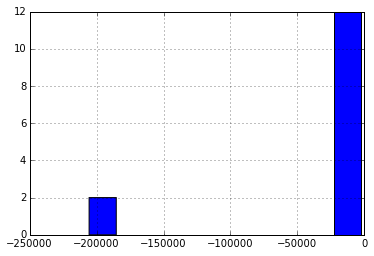

In [54]:
lambda_compensation = pd.Series(survey_scenario.simulation.calculate("lambda_compensation"))
lambda_compensation.loc[(lambda_compensation == -np.inf)|lambda_compensation.isnull()]=0
lambda_compensation.loc[(lambda_compensation == np.inf)|lambda_compensation.isnull()]=0
lambda_compensation[np.abs(lambda_compensation)-2000 >= 0 ].hist(bins = 10)
#plt.xlim(-20,20)

#### Pourcentage du sample à 0

In [55]:
lambda_compensation = pd.Series(survey_scenario.simulation.calculate("lambda_compensation"))
#lambda_compensation.loc[(lambda_compensation == -np.inf)|lambda_compensation.isnull()]=0
#lambda_compensation.loc[(lambda_compensation == np.inf)|lambda_compensation.isnull()]=0
prct1 = lambda_compensation[np.abs(lambda_compensation)==0].shape[0]/lambda_compensation.shape[0]
print "{} % du sample à un lambda égal à 0 ".format(round(prct1,2)*100)

48.0 % du sample à un lambda égal à 0 


#### Pourcentage du sample presque à 0

In [56]:
lambda_compensation = pd.Series(survey_scenario.simulation.calculate("lambda_compensation"))
lambda_compensation.loc[(lambda_compensation == -np.inf)|lambda_compensation.isnull()]=0
lambda_compensation.loc[(lambda_compensation == np.inf)|lambda_compensation.isnull()]=0
prct1 = lambda_compensation[np.abs(lambda_compensation)<0.01].shape[0]/lambda_compensation.shape[0]
print "{} % du sample à un lambda égal à 0 ".format(round(prct1,2)*100)

91.0 % du sample à un lambda égal à 0 


#### Pourcentage du sample > ou < à  0

In [57]:
lambda_compensation = pd.Series(survey_scenario.simulation.calculate("lambda_compensation"))
lambda_compensation.loc[(lambda_compensation == -np.inf)|lambda_compensation.isnull()]=0
lambda_compensation.loc[(lambda_compensation == np.inf)|lambda_compensation.isnull()]=0
prct1 = lambda_compensation[lambda_compensation<0].shape[0]/lambda_compensation.shape[0]
prct2 = lambda_compensation[lambda_compensation>0].shape[0]/lambda_compensation.shape[0]
print "{} % du sample à un lambda < à 0 ".format(round(prct1,2)*100)
print "{} % du sample à un lambda > à 0 ".format(round(prct2,2)*100)

24.0 % du sample à un lambda < à 0 
28.0 % du sample à un lambda > à 0 


In [58]:
lambda_compensation = pd.Series(survey_scenario.simulation.calculate("lambda_compensation"))
lambda_compensation.loc[(lambda_compensation == -np.inf)|lambda_compensation.isnull()]=0
lambda_compensation.loc[(lambda_compensation == np.inf)|lambda_compensation.isnull()]=0
prct1 = lambda_compensation[lambda_compensation<-0.01].shape[0]/lambda_compensation.shape[0]
prct2 = lambda_compensation[lambda_compensation>0.01].shape[0]/lambda_compensation.shape[0]
print "{} % du sample à un lambda < à -0.01 ".format(round(prct1,2)*100)
print "{} % du sample à un lambda > à 0.01 ".format(round(prct2,2)*100)

3.0 % du sample à un lambda < à -0.01 
6.0 % du sample à un lambda > à 0.01 


In [59]:
lambda_compensation = pd.Series(survey_scenario.simulation.calculate("lambda_compensation"))
lambda_compensation.loc[(lambda_compensation == -np.inf)|lambda_compensation.isnull()]=0
lambda_compensation.loc[(lambda_compensation == np.inf)|lambda_compensation.isnull()]=0
prct1 = lambda_compensation[lambda_compensation<-0.01].shape[0]/lambda_compensation[np.abs(lambda_compensation)>0.01].shape[0]
prct2 = lambda_compensation[lambda_compensation>0.01].shape[0]/lambda_compensation[np.abs(lambda_compensation)>0.01].shape[0]
print "{} % du sample à un lambda < à -0.01 ".format(round(prct1,2)*100)
print "{} % du sample à un lambda > à 0.01 ".format(round(prct2,2)*100)

29.0 % du sample à un lambda < à -0.01 
71.0 % du sample à un lambda > à 0.01 


#### Pourcentage du sample entre -20 et 20

In [60]:
lambda_compensation = pd.Series(survey_scenario.simulation.calculate("lambda_compensation"))
lambda_compensation.loc[(lambda_compensation == -np.inf)|lambda_compensation.isnull()]=0
lambda_compensation.loc[(lambda_compensation == np.inf)|lambda_compensation.isnull()]=0
prct1 = lambda_compensation[np.abs(lambda_compensation)>70].shape[0]/lambda_compensation.shape[0]
print "{} % du sample à un lambda supérieur  à 70 ".format(round(prct1,2)*100)

1.0 % du sample à un lambda supérieur  à 70 


#### Lambda compensation négatif du à la décote ?

In [61]:
pd.Series(survey_scenario.simulation.calculate_add("decote_mensuel_times_12")/12).mean()

162.66545

In [62]:
decote_monthly = pd.Series(survey_scenario.simulation.calculate_add("decote_mensuel_times_12")/12)
decote_annual =  pd.Series(survey_scenario.simulation.calculate_add("decote"))

In [63]:
filtre_unequal_decote = decote_monthly != decote_annual

In [64]:
lambda_compensation[filtre_unequal_decote].shape

(18830,)

(-20, 20)

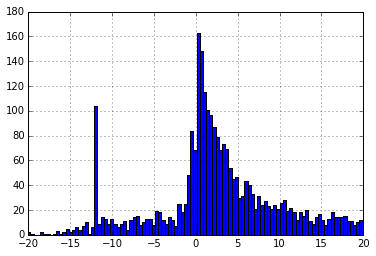

In [65]:
lambda_compensation[filtre_unequal_decote&
                    (np.abs(lambda_compensation)>.1)&
                    (np.abs(lambda_compensation)<100)].hist(bins = 500)
plt.xlim(-20,20)

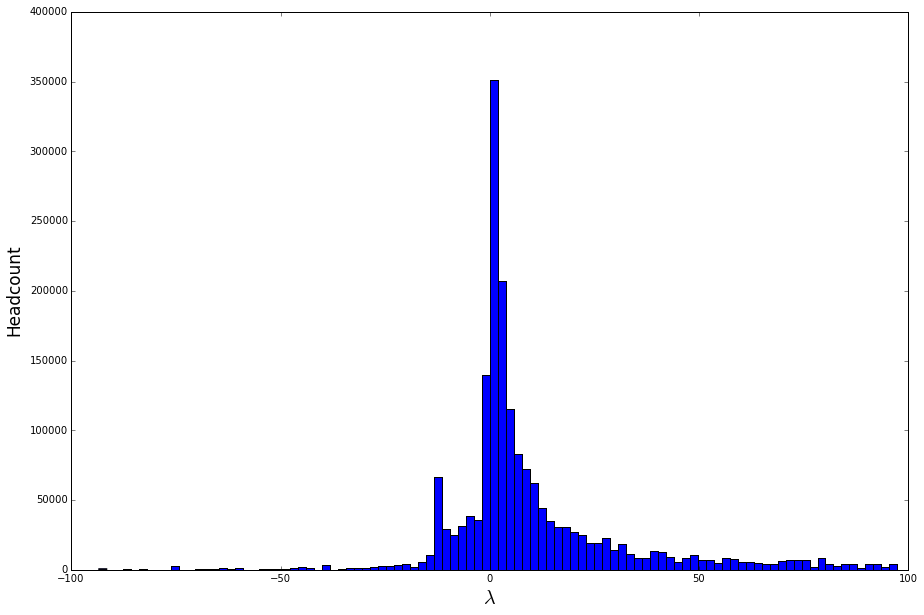

In [66]:
graph_filter = filtre_unequal_decote & (np.abs(lambda_compensation)>.1) & (np.abs(lambda_compensation)<100)


to_graph_foyer = lambda_compensation[graph_filter]
poids = pd.Series(weight_foyers)[graph_filter]

plt.figure(figsize=(15,10))
plt.hist(to_graph_foyer.values, bins = 100, weights = poids.values)
plt.xlabel(r'$\lambda$',fontsize = 20 )
plt.ylabel('Headcount',fontsize = 17)

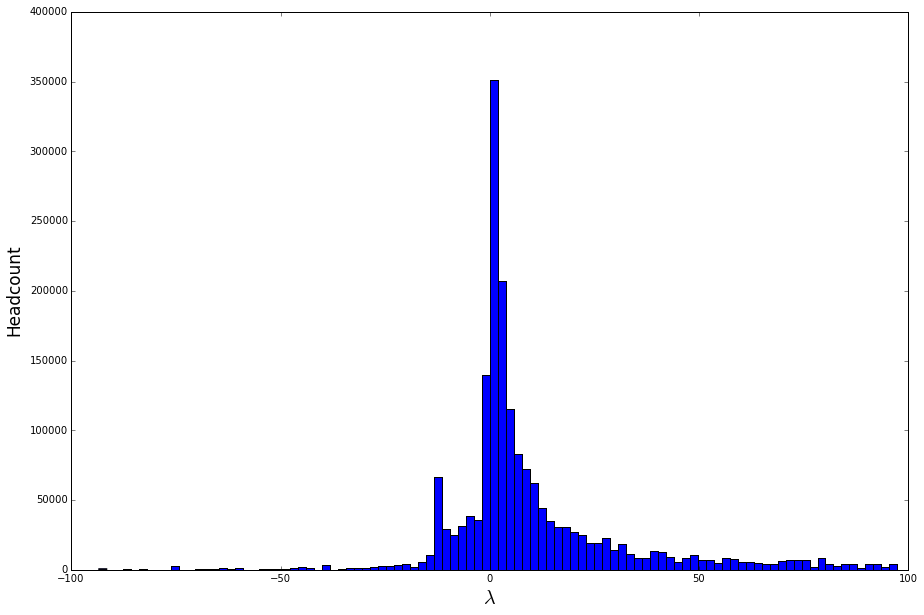

In [67]:
graph_filter = filtre_unequal_decote & (np.abs(lambda_compensation)>.1)&(np.abs(lambda_compensation)<100)


to_graph_foyer = lambda_compensation[filtre_unequal_decote&
                    (np.abs(lambda_compensation)>.1)&
                    (np.abs(lambda_compensation)<100)]
poids = pd.Series(weight_foyers)[
        filtre_unequal_decote&
        (np.abs(lambda_compensation)>.1)&
        (np.abs(lambda_compensation)<100)]

plt.figure(figsize=(15,10))
plt.hist(to_graph_foyer.values, bins = 100, weights = poids.values)
plt.xlabel(r'$\lambda$',fontsize = 20 )
plt.ylabel('Headcount',fontsize = 17)

In [68]:
lambda_compensation_menage = pd.Series(switch_entity('lambda_compensation', 'menage'))
graph_filter_menage =  (np.abs(lambda_compensation_menage)>.1)&(np.abs(lambda_compensation_menage)<100)

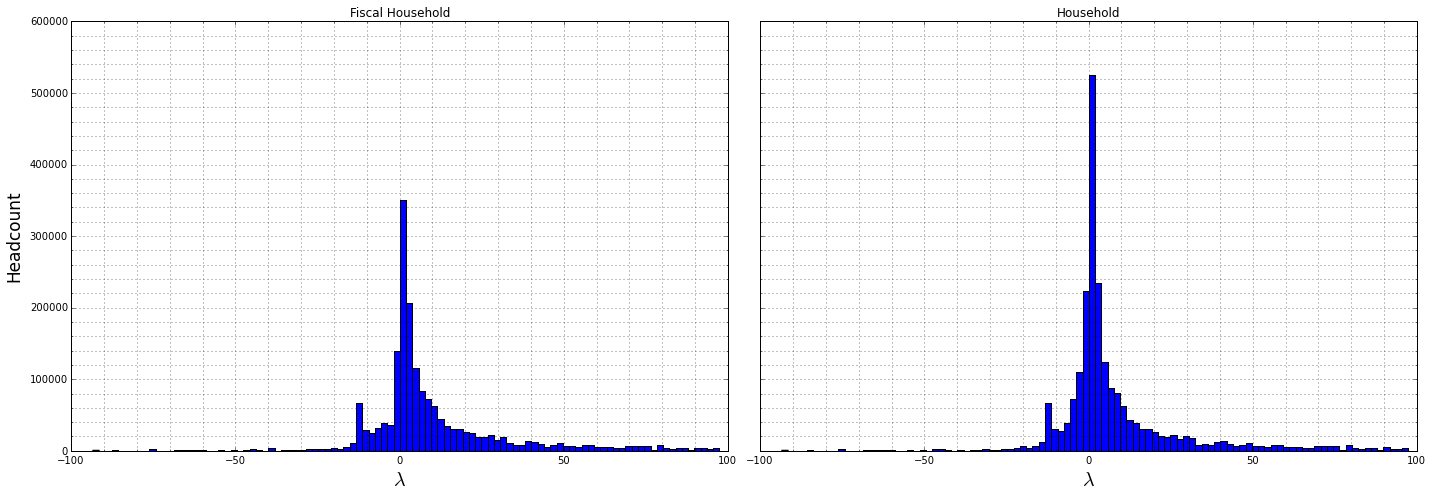

In [70]:

nb_minor_ticks = 5
fig, ax = plt.subplots(1,2,sharey = True, figsize = (20, 7), tight_layout = True)

to_graph_menage = lambda_compensation_menage[graph_filter_menage]
poids_menage = pd.Series(weight_menages)[graph_filter_menage]


ax[0].hist(to_graph_foyer.values, bins = 100, weights = poids.values)
ax[0].set_xlabel(r'$\lambda$',fontsize = 20 )
ax[0].set_ylabel('Headcount',fontsize = 17)
ax[0].set_title('Fiscal Household')
ax[0].xaxis.set_minor_locator(AutoMinorLocator(nb_minor_ticks))
ax[0].yaxis.set_minor_locator(AutoMinorLocator(nb_minor_ticks))
ax[0].grid(which = 'both')



ax[1].hist(to_graph_menage.values, bins = 100, weights = poids_menage.values)
ax[1].set_xlabel(r'$\lambda$',fontsize = 20)
#ax[1].set_ylabel('Headcount',fontsize = 17)
ax[1].set_title('Household')
ax[1].xaxis.set_minor_locator(AutoMinorLocator(nb_minor_ticks))
ax[1].yaxis.set_minor_locator(AutoMinorLocator(nb_minor_ticks))
ax[1].grid(which = 'both')

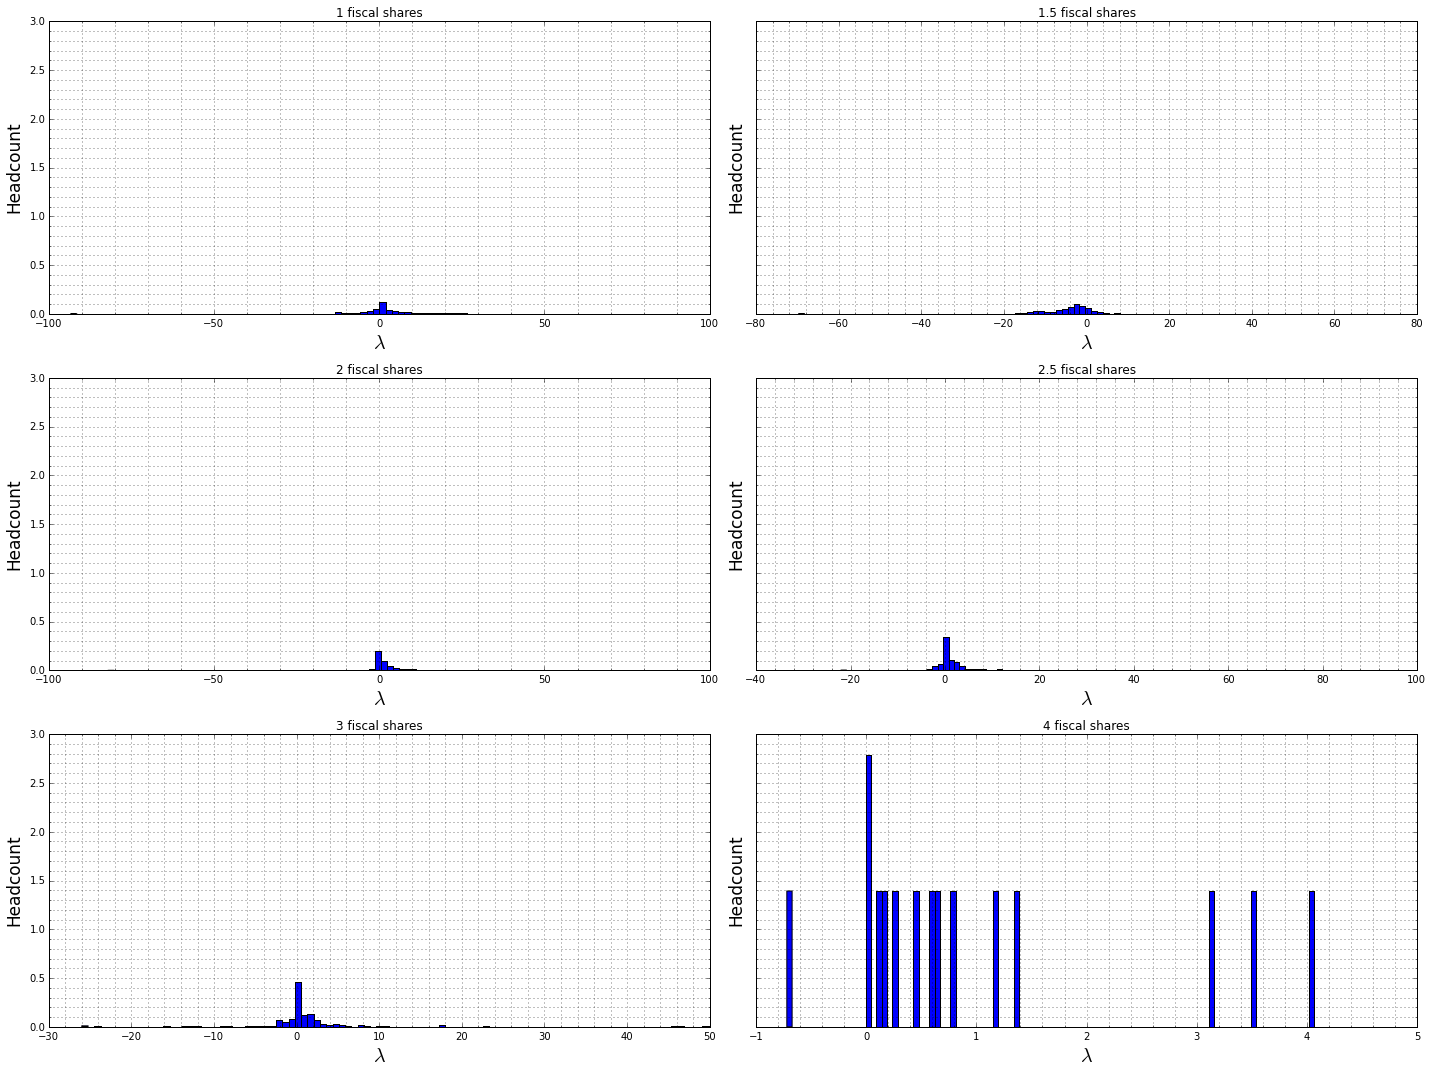

In [71]:
from matplotlib.ticker import AutoMinorLocator
nb_parts_list = [1,1.5,2,2.5,3,4]
graph_filter = (np.abs(lambda_compensation)>.1)&(np.abs(lambda_compensation)<100)

nb_subplots_lines = len(nb_parts_list)//2 + len(nb_parts_list)%2 

fig, ax = plt.subplots(nb_subplots_lines,2,sharey = True, figsize = (20, 15), tight_layout = True)
count = 0
for parts in nb_parts_list:
    graph_filter = (np.abs(lambda_compensation)>.001)&(np.abs(lambda_compensation)<100) & (simulation.calculate('nbptr') == parts)
    i = count//2
    j = count %2
    
    ax[i,j].hist(lambda_compensation[graph_filter].values, bins = 100, normed = True)#, weights = poids.values)
    ax[i,j].set_xlabel(r'$\lambda$',fontsize = 20 )
    ax[i,j].set_ylabel('Headcount',fontsize = 17)
    ax[i,j].set_title('{} fiscal shares'.format(parts))
    ax[i,j].xaxis.set_minor_locator(AutoMinorLocator(nb_minor_ticks))
    ax[i,j].yaxis.set_minor_locator(AutoMinorLocator(nb_minor_ticks))
    ax[i,j].grid(which = 'both')
    count +=1
plt.savefig("image_result_of_mensualisation/lambda_compensation_by_fiscal_shares.png")

In [75]:
print to_graph_foyer.shape
print poids_menage.shape

(15,)
(4222,)


In [76]:
#to_graph_foyer = lambda_compensation[graph_filter]
#poids_menage = pd.Series(weight_menages)[graph_filter_menage]

#plt.figure(figsize=(15,10))
#plt.hist(to_graph_foyer.values, bins = 100, weights = poids.values)
#plt.xlabel(r'$\lambda$',fontsize = 20 )
#plt.ylabel('Headcount',fontsize = 17)

In [78]:
#from matplotlib.ticker import AutoMinorLocator
#nb_minor_ticks = 5
#fig, ax = plt.subplots(1,2,sharey = True, figsize = (20, 7), tight_layout = True)

#to_graph_menage = lambda_compensation_menage[graph_filter_menage]
#poids_menage = pd.Series(weight_menages)[graph_filter_menage]
#ax_nb = 0
#ax[ax_nb].hist(to_graph_foyer.values, bins = 100,normed = True, weights = poids.values)
#ax[ax_nb].set_xlabel(r'$\lambda$',fontsize = 20 )
#ax[ax_nb].set_ylabel('Headcount',fontsize = 17)
#ax[ax_nb].set_title('Fiscal Household')
#ax[ax_nb].xaxis.set_minor_locator(AutoMinorLocator(nb_minor_ticks))
#ax[ax_nb].yaxis.set_minor_locator(AutoMinorLocator(nb_minor_ticks))
#ax[ax_nb].grid(which = 'both')


#ax_nb = 1
#ax[ax_nb].hist(to_graph_menage.values, bins = 100, normed = True ,weights = poids_menage.values)
#ax[ax_nb].set_xlabel(r'$\lambda$',fontsize = 20)
##ax[1].set_ylabel('Headcount',fontsize = 17)
#ax[ax_nb].set_title('Household')
#ax[ax_nb].xaxis.set_minor_locator(AutoMinorLocator(nb_minor_ticks))
#ax[ax_nb].yaxis.set_minor_locator(AutoMinorLocator(nb_minor_ticks))
#ax[ax_nb].grid(which = 'both')

In [79]:
to_graph_menage = lambda_compensation[filtre_unequal_decote&
                    (np.abs(lambda_compensation)>.1)&
                    (np.abs(lambda_compensation)<100)]

In [80]:
lambda_zero = pd.Series(lambda_compensation == 0 )
pd.Series(weight_foyers)[lambda_zero].sum()



13148638.0

In [81]:
index_exceptional_lambda = lambda_compensation[np.abs(lambda_compensation)>100].index

In [82]:
df = survey_scenario.create_data_frame_by_entity_key_plural(['decote_gain_fiscal','decote_gain_fiscal_mensuel_times_12',"irpp",'irpp_mensuel', 'lambda_compensation'])['foyers_fiscaux']
df['decote_gain_fiscal_mensuel'] = df.decote_gain_fiscal_mensuel_times_12/12
df.iloc[index_exceptional_lambda]

,decote_gain_fiscal,decote_gain_fiscal_mensuel_times_12,irpp,irpp_mensuel,lambda_compensation,decote_gain_fiscal_mensuel
79,220.742493,0.000000,-203.772522,-2905.329102,159.092499,0.000000
448,98.049988,0.000000,-235.850037,-2587.437500,119.648270,0.000000
730,82.772491,0.000000,-356.762482,-4471.346680,138.397430,0.000000
1074,103.964996,0.000000,-554.104980,-5264.925293,102.020096,0.000000
1175,206.812500,0.000000,-245.562500,-2514.979248,110.900482,0.000000
1295,221.792496,0.000000,-200.622513,-2361.193848,129.232040,0.000000
1653,37.563751,697.702209,-70.808716,-1098.462402,174.157150,58.141850
1850,210.802505,0.000000,-233.592484,-2962.196045,140.172501,0.000000
1968,254.062500,0.000000,-103.812500,-1205.469849,127.343903,0.000000
2292,227.252502,0.000000,-123.242493,-1438.893433,128.103638,0.000000


In [83]:
survey_scenario.simulation.calculate("irpp_mensuel","2009-08")[4]

-196.90581

In [84]:
df["difference"] = np.abs(df.decote_gain_fiscal- df.decote_gain_fiscal_mensuel)>0.01
df[lambda_compensation == -12].difference.value_counts()

True     94
False     4
dtype: int64

In [85]:
df.shape

(52189, 7)

In [86]:
df[lambda_compensation == -12][['decote_gain_fiscal', 'decote_gain_fiscal_mensuel', 'lambda_compensation',"irpp",'irpp_mensuel' ]]

,decote_gain_fiscal,decote_gain_fiscal_mensuel,lambda_compensation,irpp,irpp_mensuel
645,157.952423,239.030014,-12,-392.142731,-0
1221,257.068756,273.102509,-12,-94.793732,-0
2235,211.432495,207.514969,-12,-231.702515,-0
2342,196.172501,251.020004,-12,-277.482483,-0
2904,197.922501,82.885002,-12,-272.232483,-0
3035,231.988785,257.262482,-12,-170.033646,-0
3283,257.756256,201.987473,-12,-92.731232,-0
3571,254.827515,0.000000,-12,-101.517456,-0
3801,252.522507,0.000000,-12,-108.432480,-0
3823,118.962494,204.324966,-12,-509.112518,-0


In [87]:
df = survey_scenario.create_data_frame_by_entity_key_plural(['decote_gain_fiscal','decote_gain_fiscal_mensuel_times_12',"irpp",'irpp_mensuel', 'lambda_compensation'])['foyers_fiscaux']
df.decote_gain_fiscal_mensuel_times_12 = df.decote_gain_fiscal_mensuel_times_12/12
df.lambda_compensation[df.lambda_compensation>70] = 0 #autrement les histogrames prennent trois heures à grapher pour quelques observations
df.lambda_compensation[df.lambda_compensation< -70] = 0

In [88]:
df[np.abs(df.decote_gain_fiscal-df.decote_gain_fiscal_mensuel_times_12)+1>0].shape

(52189, 5)

(-20, 20)

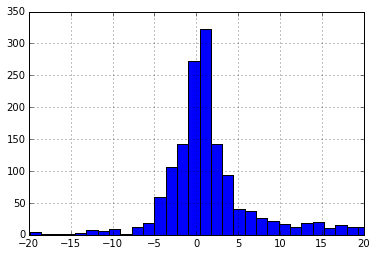

In [89]:
df.lambda_compensation[(np.abs(df.decote_gain_fiscal-df.decote_gain_fiscal_mensuel_times_12)-1<0)
                      & (np.abs(df.lambda_compensation)>0.1)].hist(bins = 100)
plt.xlim(-20,20)

In [90]:
df.lambda_compensation[(np.abs(df.decote_gain_fiscal-df.decote_gain_fiscal_mensuel_times_12)-0.1>0)
                      & (np.abs(df.lambda_compensation)>0.1)].mean()

6.0022254

In [91]:
df[(np.abs(df.decote_gain_fiscal-df.decote_gain_fiscal_mensuel_times_12)-0.1>0)
                      & (np.abs(df.lambda_compensation)>0.1)]

,decote_gain_fiscal,decote_gain_fiscal_mensuel_times_12,irpp,irpp_mensuel,lambda_compensation
4,222.102493,0.000000,-199.692520,-984.529053,47.162701
8,69.080002,50.640320,153.500000,-124.341667,-21.720520
50,-0.000000,99.622520,-950.567383,-1119.121704,2.127837
65,16.202515,0.000000,-817.392456,-5112.797852,63.060120
89,-0.000000,154.382523,-1009.715027,-402.852509,-7.212283
133,229.637497,56.897495,-107.587509,-364.255066,28.627956
146,32.442505,0.000000,-768.672485,-1047.363403,4.350737
152,154.163757,81.883415,-403.508728,-470.173218,1.982544
186,39.092499,118.306862,-748.722534,-294.579407,-7.278688
188,133.312500,0.000000,-421.062500,-804.537537,10.928782


In [92]:
df[df.lambda_compensation<-1]

,decote_gain_fiscal,decote_gain_fiscal_mensuel_times_12,irpp,irpp_mensuel,lambda_compensation
8,69.080002,50.640320,153.500000,-124.341667,-21.720520
41,-0.000000,-0.000000,-1097.812744,-773.432434,-3.545745
89,-0.000000,154.382523,-1009.715027,-402.852509,-7.212283
100,-0.000000,-0.000000,-1094.807129,-877.527771,-2.381563
186,39.092499,118.306862,-748.722534,-294.579407,-7.278688
392,-0.000000,0.000000,-1409.734985,272.399994,-14.318733
486,-0.000000,-0.000000,-1104.777588,-1007.197327,-1.059908
628,152.197510,232.167496,-73.407471,166.502502,-39.218346
645,157.952423,239.030014,-392.142731,-0.000000,-12.000000
707,-0.000000,-0.000000,-14681.409180,-12211.808594,-2.018554


In [93]:
df[df.lambda_compensation<-1][df.decote_gain_fiscal> df.decote_gain_fiscal_mensuel_times_12]

/usr/local/lib/python2.7/site-packages/pandas/core/frame.py:1825: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  "DataFrame index.", UserWarning)


,decote_gain_fiscal,decote_gain_fiscal_mensuel_times_12,irpp,irpp_mensuel,lambda_compensation
8,69.080002,50.640320,153.500000,-124.341667,-21.720520
1391,284.445007,63.286880,267.835022,-179.139389,-20.026108
1587,98.505005,10.954166,658.315063,422.085144,-4.306083
2120,278.614990,199.355637,116.845001,-28.473122,-14.924194
2235,211.432495,207.514969,-231.702515,-0.000000,-12.000000
2904,197.922501,82.885002,-272.232483,-0.000000,-12.000000
3231,171.322357,0.000000,87.967072,-303.172577,-53.357189
3283,257.756256,201.987473,-92.731232,-0.000000,-12.000000
3321,175.929993,1.549131,1230.989990,-370.053955,-15.607379
3571,254.827515,0.000000,-101.517456,-0.000000,-12.000000


## Compensated irpp

In [94]:
print max(pd.Series(survey_scenario.simulation.calculate_add('compensated_irpp_mensuel') -  survey_scenario.simulation.calculate_add('irpp')))
print min(pd.Series(survey_scenario.simulation.calculate_add('compensated_irpp_mensuel') -  survey_scenario.simulation.calculate_add('irpp')))

0.09375
-0.046875


In [95]:
df = survey_scenario.create_data_frame_by_entity_key_plural(['decote_gain_fiscal','decote_gain_fiscal_mensuel_times_12',"irpp",'irpp_mensuel', 'lambda_compensation', 'compensated_irpp_mensuel'])['foyers_fiscaux']
df.decote_gain_fiscal_mensuel_times_12 = df.decote_gain_fiscal_mensuel_times_12/12
#df.lambda_compensation[df.lambda_compensation>70] = 0 #autrement les histogrames prennent trois heures à grapher pour quelques observations
#df.lambda_compensation[df.lambda_compensation< -70] = 0
#df.compensated_irpp_mensuel = df.compensated_irpp_mensuel
df

,compensated_irpp_mensuel,decote_gain_fiscal,decote_gain_fiscal_mensuel_times_12,irpp,irpp_mensuel,lambda_compensation
0,0.000000,5.894867,21.742493,0.000000,-9.912071,0.000000e+00
1,0.000000,0.000000,77.137505,0.000000,-0.000000,0.000000e+00
2,0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000e+00
3,-1378.829712,-0.000000,-0.000000,-1378.829712,-1378.829956,1.907349e-06
4,-199.692520,222.102493,0.000000,-199.692520,-984.529053,4.716270e+01
5,-792.612549,24.462494,24.462494,-792.612549,-792.612366,-2.861023e-06
6,-11461.149414,-0.000000,-0.000000,-11461.150391,-11461.149414,-9.536743e-07
7,0.000000,102.025002,155.870041,0.000000,-0.000000,0.000000e+00
8,153.500031,69.080002,50.640320,153.500000,-124.341667,-2.172052e+01
9,-2104.827637,-0.000000,-0.000000,-2104.827637,-2104.827881,9.536743e-07


In [96]:
df = survey_scenario.create_data_frame_by_entity_key_plural(['decote_gain_fiscal','decote_gain_fiscal_mensuel_times_12',"irpp",'irpp_mensuel', 'lambda_compensation', 'compensated_irpp_mensuel'])['foyers_fiscaux']
df.decote_gain_fiscal_mensuel_times_12 = df.decote_gain_fiscal_mensuel_times_12/12
#df.lambda_compensation[df.lambda_compensation>70] = 0 #autrement les histogrames prennent trois heures à grapher pour quelques observations
#df.lambda_compensation[df.lambda_compensation< -70] = 0
#df.compensated_irpp_mensuel = df.compensated_irpp_mensuel
df

,compensated_irpp_mensuel,decote_gain_fiscal,decote_gain_fiscal_mensuel_times_12,irpp,irpp_mensuel,lambda_compensation
0,0.000000,5.894867,21.742493,0.000000,-9.912071,0.000000e+00
1,0.000000,0.000000,77.137505,0.000000,-0.000000,0.000000e+00
2,0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000e+00
3,-1378.829712,-0.000000,-0.000000,-1378.829712,-1378.829956,1.907349e-06
4,-199.692520,222.102493,0.000000,-199.692520,-984.529053,4.716270e+01
5,-792.612549,24.462494,24.462494,-792.612549,-792.612366,-2.861023e-06
6,-11461.149414,-0.000000,-0.000000,-11461.150391,-11461.149414,-9.536743e-07
7,0.000000,102.025002,155.870041,0.000000,-0.000000,0.000000e+00
8,153.500031,69.080002,50.640320,153.500000,-124.341667,-2.172052e+01
9,-2104.827637,-0.000000,-0.000000,-2104.827637,-2104.827881,9.536743e-07


In [97]:
df[df.compensated_irpp_mensuel - df.irpp<2][['irpp', 'compensated_irpp_mensuel', 'irpp_mensuel']]

,irpp,compensated_irpp_mensuel,irpp_mensuel
0,0.000000,0.000000,-9.912071
1,0.000000,0.000000,-0.000000
2,0.000000,0.000000,-0.000000
3,-1378.829712,-1378.829712,-1378.829956
4,-199.692520,-199.692520,-984.529053
5,-792.612549,-792.612549,-792.612366
6,-11461.150391,-11461.149414,-11461.149414
7,0.000000,0.000000,-0.000000
8,153.500000,153.500031,-124.341667
9,-2104.827637,-2104.827637,-2104.827881


In [98]:
print survey_scenario.compute_aggregate('compensated_irpp_mensuel')
print survey_scenario.compute_aggregate('irpp')

-46144263353.3
-46144263289.7


In [99]:
impot_mensuel_times_12 = survey_scenario.simulation.calculate("irpp_mensuel", period)*12
lambda_compensation = survey_scenario.simulation.calculate("lambda_compensation", period.this_year)



compensated_irpp = impot_mensuel_times_12/(12 + lambda_compensation)

In [100]:
compensated_irpp[743]

0.00022888184

In [101]:
(survey_scenario.simulation.calculate("irpp", period.this_year) == 0)*0

array([0, 0, 0, ..., 0, 0, 0])

In [102]:
compensated_irpp = (survey_scenario.simulation.calculate("irpp", period.this_year) == 0) * 0 + \
                ~(survey_scenario.simulation.calculate("irpp", period.this_year) == 0) * np.nan_to_num(compensated_irpp) ;compensated_irpp[[4,743]]

array([-199.69252014,    0.        ])

In [103]:
compensated_irpp = (
                (survey_scenario.simulation.calculate_add("irpp_mensuel", period) == 0) * #Condition
                (survey_scenario.simulation.calculate("irpp", period.this_year)/12) # on répartit sur l'année
            ) + ~(survey_scenario.simulation.calculate_add("irpp_mensuel", period) == 0) * compensated_irpp #condition opposée
compensated_irpp[[4,743]]

array([-199.69252014,    0.        ])

In [104]:
df[df.lambda_compensation.isnull()]

,compensated_irpp_mensuel,decote_gain_fiscal,decote_gain_fiscal_mensuel_times_12,irpp,irpp_mensuel,lambda_compensation


In [105]:
survey_scenario.simulation.calculate_add('irpp')

array([ 0.,  0.,  0., ...,  0.,  0.,  0.], dtype=float32)

In [106]:
survey_scenario.compute_aggregate('compensated_irpp_mensuel')

-46144263353.327835

In [107]:
lambda_compensation = survey_scenario.simulation.calculate('lambda_compensation')
np.all(lambda_compensation != np.nan)
lambda_compensation != np.nan
hello = lambda_compensation[1]
assert np.all(np.isfinite(lambda_compensation))


In [108]:
sal_pen_df = survey_scenario.create_data_frame_by_entity_key_plural_with_monthly_basis_selector(['irpp'], ['irpp_mensuel','compensated_irpp_mensuel'])['foyers_fiscaux']

sal_pen_df.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,...,52089,52090,52091,52092,52093,52094,52095,52096,52097,52098,52099,52100,52101,52102,52103,52104,52105,52106,52107,52108,52109,52110,52111,52112,52113,52114,52115,52116,52117,52118,52119,52120,52121,52122,52123,52124,52125,52126,52127,52128,52129,52130,52131,52132,52133,52134,52135,52136,52137,52138,52139,52140,52141,52142,52143,52144,52145,52146,52147,52148,52149,52150,52151,52152,52153,52154,52155,52156,52157,52158,52159,52160,52161,52162,52163,52164,52165,52166,52167,52168,52169,52170,52171,52172,52173,52174,52175,52176,52177,52178,52179,52180,52181,52182,52183,52184,52185,52186,52187,52188
irpp,0.000000,0,0,-1378.829712,-199.692520,-792.612549,-11461.150391,0,153.500000,-2104.827637,0,-693.510254,-5236.649902,-2124.675049,737.799988,0.000000,-1072.575317,-1089.632202,-433.722321,0,0.00000,-1747.150024,0.000000,0,-2433.450195,-79.077332,-5260.950195,-568.148743,-2369.692871,-8168.149902,-7609.375000,0.000000,-700.632874,0,0,0,0,0,-613.062317,-557.202698,-1022.315002,-1097.812744,0.00000,-100.774826,0,-1177.890015,0,-1053.290039,-176.052505,-25070.472656,-950.567383,0.000000,-7382.575195,0.000000,-464.382507,-19810.775391,-306.282501,-839.862549,-2150.909424,0,-3082.330078,-1024.974365,221.765015,-781.379395,0,-817.392456,-1687.875000,-2443.069336,-712.655029,-1361.430542,-504.814941,-1770.290039,0.000000,0,-244.102661,-607.182739,-97.092316,-1016.015015,-1271.149414,-203.772522,0,-1550.395020,-320.322510,0,-1681.944946,0,0,0,0,-1009.715027,-188.301331,-505.332306,0.000000,-184.677505,-1057.435059,0,-651.175049,229.050049,-30161.775391,-24377.976562,...,-8082.973633,-2029.989990,0,0,-4311.649902,0,0.000000,-138.734985,-1745.834961,-3921.609375,-466.745026,-289.197540,0,0,-1462.055054,-2327.509766,0,0,-254.307480,-2161.594971,-100.692520,0.000000,-601.302246,0.00000,-1093.915039,0,-4020.969971,-1445.395020,0,-1058.574951,-2052.189941,-267.612518,-499.992493,-4005.529785,-319.692688,-563.888794,0,-4398.748535,-2004.694702,-687.770264,-748.354553,-244.002533,-1644.449951,-12232.699219,-1885.730469,0,-1735.875000,-6221.949707,720.587524,0,0,0,0,0,-1870.689941,0,-1313.714966,0,-694.752075,-130.433609,0,-2510.689941,-122.678955,0,-881.647339,0,-1013.949707,0,-2144.870117,-1179.814941,-1846.975098,-820.122070,-15807.650391,-476.045013,0,-994.734985,-1435.174683,-1254.364868,-322.212524,0,0,-2653.750000,0,0,0,0,-15008.900391,-315.072510,0,-7257.774902,-2652.369873,-3179.347412,0.000000,-2050.929932,-198.942520,-1824.654785,0,0.000000,0,0
compensated_irpp_mensuel_2009-01,0.000000,0,0,-114.902489,0.000000,-66.051056,-955.095947,0,-15.791336,-175.402283,0,-57.792530,-436.387512,-177.056259,61.483326,0.000000,-89.381279,-90.802673,-36.143524,0,0.00000,-145.595840,0.000000,0,-202.787506,-6.589777,-438.412476,-47.345730,-197.474411,-680.679138,-634.114563,0.000000,-58.386074,0,0,0,0,0,-51.088524,-46.433563,-85.192909,-91.484406,0.00000,-8.397902,0,-98.157509,0,-87.774170,-14.671043,-2089.205811,-18.735966,0.000000,-615.214478,0.000000,-38.698540,-1650.897705,-25.523539,-69.988548,-179.242477,0,-256.860840,-85.414520,18.480419,-65.114952,0,0.000000,-337.574982,-203.589127,-59.387913,-113.452560,-42.067917,-147.524170,0.000000,0,-20.341888,-50.598564,-8.091026,-84.667923,-105.929115,-101.886261,0,-129.199585,-26.693544,0,-140.162064,0,0,0,0,-84.142914,-15.691777,-42.111023,0.000000,-15.389793,-88.119606,0,-54.264587,19.087505,-2513.481689,-2031.498047,...,-673.581177,-220.328247,0,0,-379.145966,0,0.000000,-11.561249,-145.486252,-326.800812,-38.895420,-24.099794,0,0,-121.837944,-193.959122,0,0,-1.754395,-180.132919,-8.391043,0.000000,-50.108521,0.00000,-91.159599,0,-335.080841,-289.078979,0,-88.214569,-171.015808,-22.301043,-41.666039,-15.985154,-26.641

In [109]:
survey_scenario.compute_aggregate('compensated_irpp_mensuel')

-46144263353.327835

## Utility annalysis 

In [110]:
survey_scenario.compute_aggregate("utility_ir_annuel") #TODO : find why Nan

-2704.216044963001

In [111]:
print pd.Series(survey_scenario.simulation.calculate_add('utility_ir_annuel','2009')).mean()
print pd.Series(survey_scenario.simulation.calculate_add('utility_ir_mensuel','2009')).mean()
print pd.Series(survey_scenario.simulation.calculate_add('utility_compensated_ir_mensuel','2009')).mean()
print pd.Series(survey_scenario.simulation.calculate_add('utility_ir_mensuel_rsa_mensuel','2009')).mean()

-0.000123577
-0.0001232
-0.000123217
-0.00445363


In [112]:
u_ir_m_rsa_m = pd.Series(survey_scenario.simulation.calculate_add('utility_ir_mensuel_rsa_mensuel','2009'))
u_c_ir = pd.Series(survey_scenario.simulation.calculate_add('utility_compensated_ir_mensuel','2009'))
u_ir_m = pd.Series(survey_scenario.simulation.calculate_add('utility_ir_mensuel','2009'))
u_ir_a = pd.Series(survey_scenario.simulation.calculate_add('utility_ir_annuel','2009'))


In [113]:
print u_ir_m_rsa_m.mean(),1/u_ir_m_rsa_m.mean()
print u_c_ir.mean(),1/u_c_ir.mean()
print u_ir_m.mean(),1/u_ir_m.mean()
print u_ir_a.mean(),1/u_ir_a.mean()

-0.00445363 -224.535860506
-0.000123217 -8115.7802742
-0.0001232 -8116.87404138
-0.000123577 -8092.11572473


In [114]:
print u_c_ir.describe()
print u_ir_m.describe()
print u_ir_a.describe()

count    42709.000000
mean        -0.000123
std          0.000083
min         -0.000434
25%         -0.000141
50%         -0.000101
75%         -0.000073
max         -0.000008
dtype: float64
count    42709.000000
mean        -0.000123
std          0.000083
min         -0.000434
25%         -0.000141
50%         -0.000101
75%         -0.000073
max         -0.000008
dtype: float64
count    42709.000000
mean        -0.000124
std          0.000083
min         -0.000434
25%         -0.000141
50%         -0.000102
75%         -0.000073
max         -0.000008
dtype: float64


In [115]:
print 1/u_c_ir.describe()
print 1/u_ir_m.describe()
print 1/u_ir_a.describe()

count         0.000023
mean      -8115.780274
std       12110.874692
min       -2304.382731
25%       -7094.270036
50%       -9864.744415
75%      -13744.814875
max     -125075.249431
dtype: float64
count         0.000023
mean      -8116.874041
std       12115.583892
min       -2304.382731
25%       -7096.627614
50%       -9861.831663
75%      -13744.368153
max     -125075.249431
dtype: float64
count         0.000023
mean      -8092.115725
std       12065.320855
min       -2304.382731
25%       -7079.973581
50%       -9851.574653
75%      -13721.592271
max     -125075.249431
dtype: float64


(0, 200)

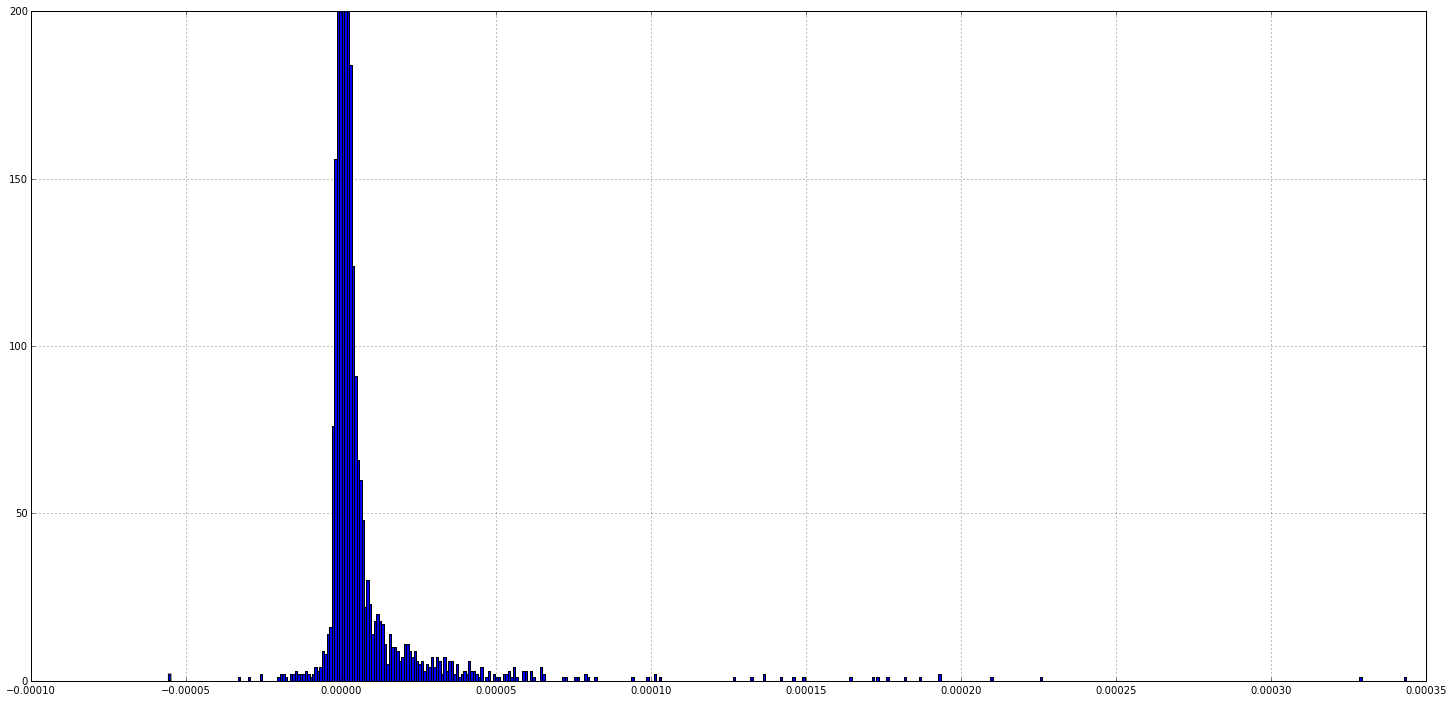

In [116]:
((u_ir_m - u_ir_a)).hist(bins = 500, figsize = (25,12))
plt.ylim(0,200)

In [117]:
((u_ir_m - u_ir_a)<-0.0000001).value_counts()

False    39787
True      2922
dtype: int64

(0, 200)

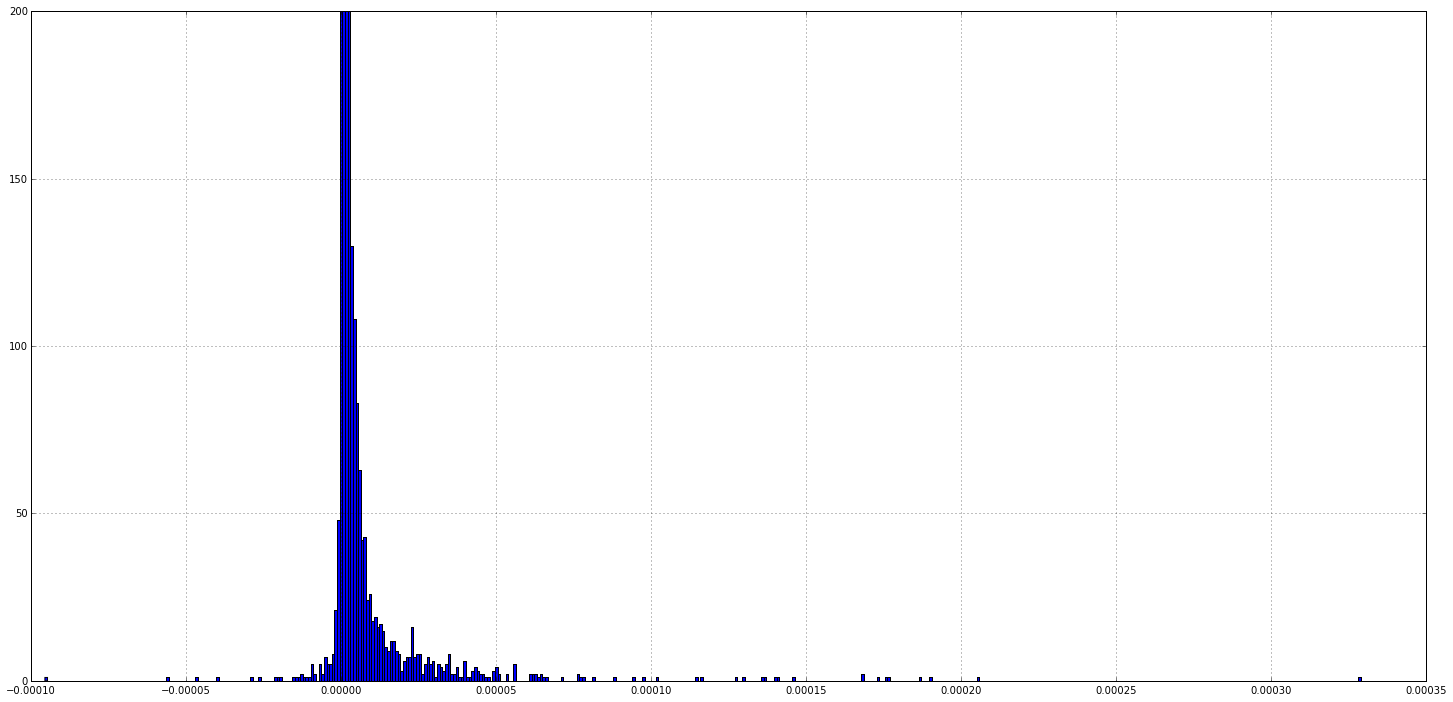

In [118]:
((u_c_ir - u_ir_a)).hist(bins = 500, figsize = (25,12))
plt.ylim(0,200)

In [119]:
((u_c_ir - u_ir_a)<-0.0000001).value_counts()

False    42455
True       254
dtype: int64

##### Graphs with weights

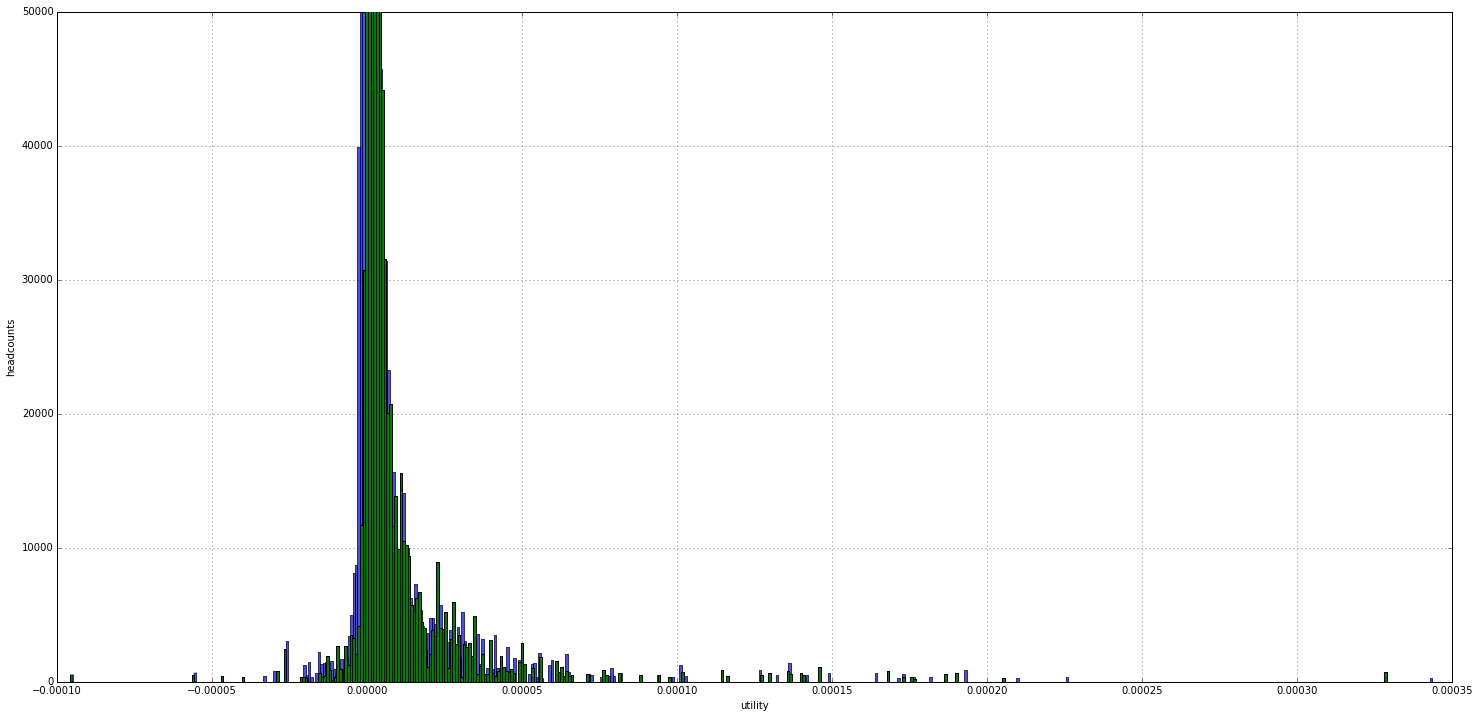

In [120]:
((u_ir_m - u_ir_a)).hist(bins = 500, figsize = (25,12), zorder=1, alpha = 0.7, weights = weight_menages,)
((u_c_ir - u_ir_a)).hist(bins = 500, figsize = (25,12), weights = weight_menages,zorder=10, alpha = 1)
plt.ylim(0,5*10**4)
plt.xlabel('utility')
plt.ylabel('headcounts')

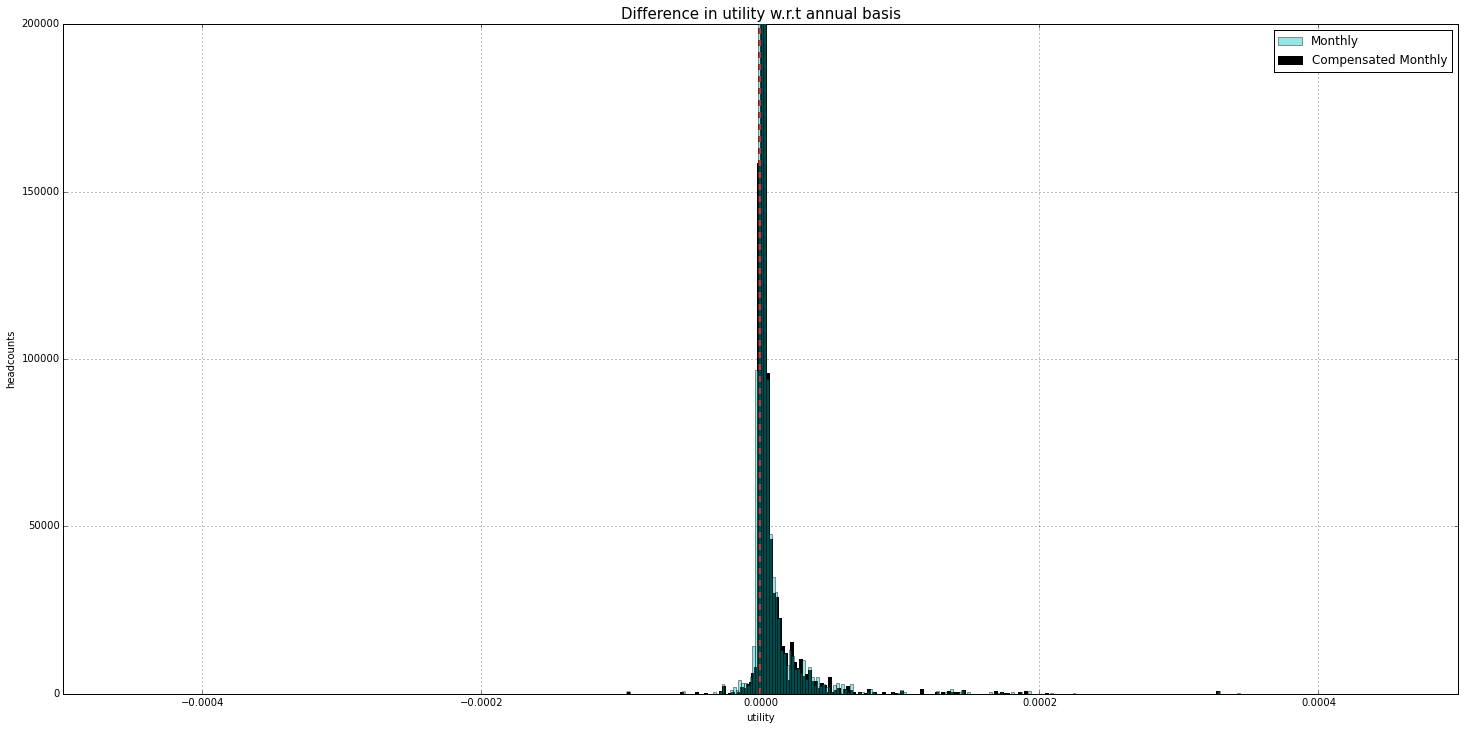

In [121]:
hist1 = ((u_ir_m - u_ir_a)).hist(bins = 200, figsize = (25,12), weights = weight_menages, zorder=10, color = 'c', alpha = 0.4, label = "Monthly")
hist2 = ((u_c_ir - u_ir_a)).hist(bins = 200, figsize = (25,12), weights = weight_menages,zorder=1, color = 'k',alpha = 1, label = "Compensated Monthly")

plt.axvline(x=0, ymax = 10**6, linewidth=4, color = 'r', alpha = 1, linestyle='dashed')
plt.ylim(0,20*10**4)
plt.xlim(-0.0005, 0.0005)
plt.legend()
plt.title("Difference in utility w.r.t annual basis", size = 15)
plt.xlabel('utility')
plt.ylabel('headcounts')

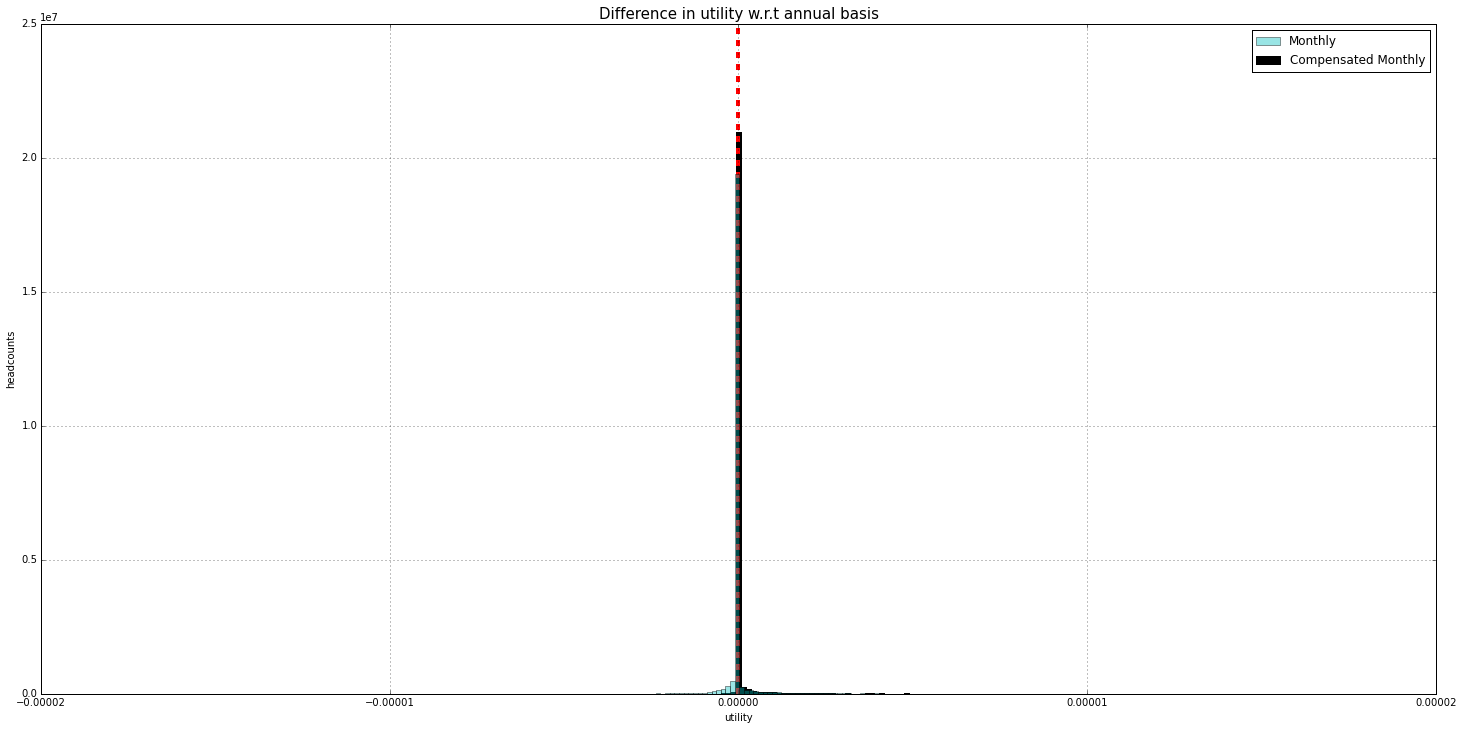

In [122]:
hist1 = ((u_ir_m - u_ir_a)).hist(bins = 3000, figsize = (25,12), weights = weight_menages, zorder=10, color = 'c', alpha = 0.4, label = "Monthly")
hist2 = ((u_c_ir - u_ir_a)).hist(bins = 3000, figsize = (25,12), weights = weight_menages,zorder=1, color = 'k',alpha = 1, label = "Compensated Monthly")

plt.axvline(x=0, ymax = 10**6, linewidth=4, color = 'r', alpha = 1, linestyle='dashed')
#plt.ylim(0,70*10**5)
plt.xlim(-0.00002, 0.00002)
plt.legend()
plt.title("Difference in utility w.r.t annual basis", size = 15)
plt.xlabel('utility')
plt.ylabel('headcounts')

In [123]:
weight_menages = pd.Series(weight_menages)

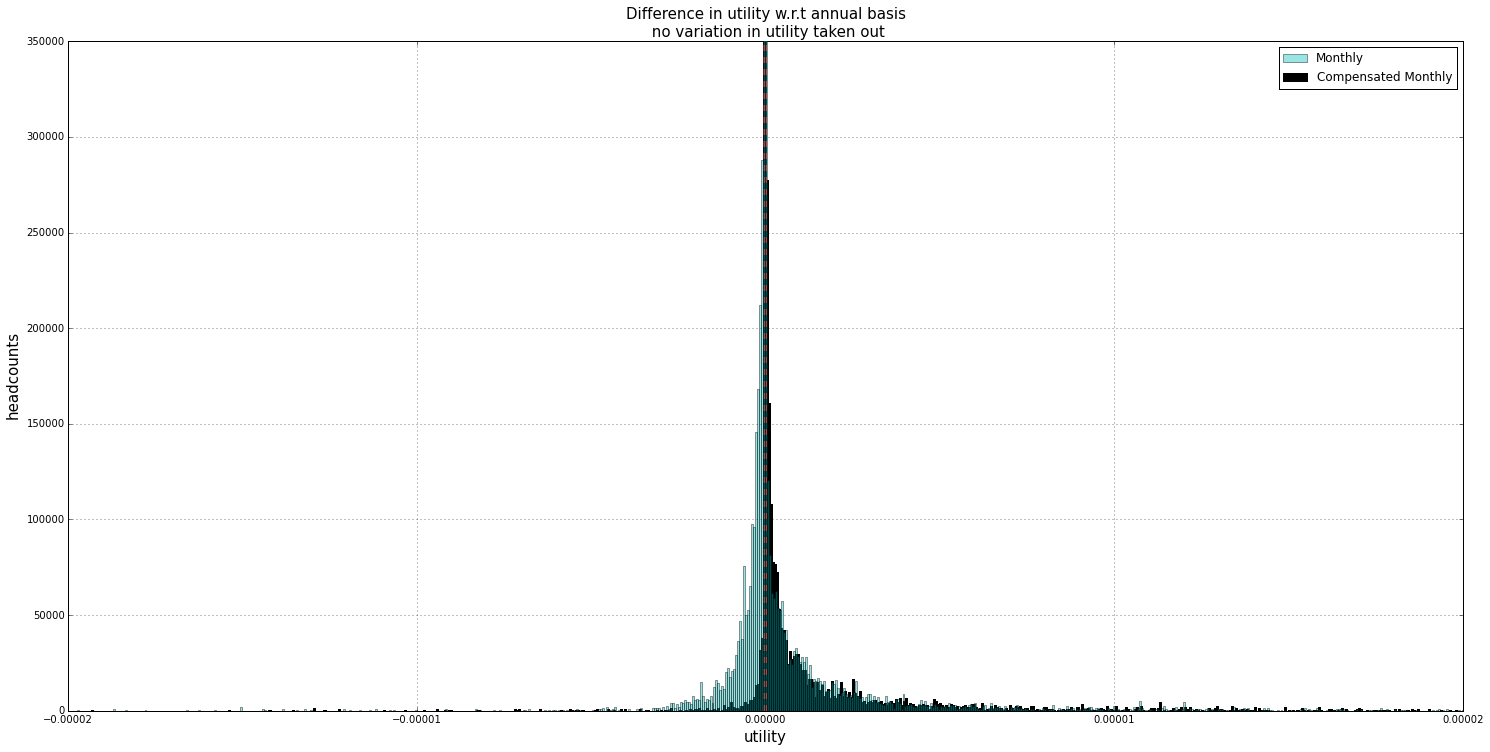

In [124]:
execute_time_consuming_graph = True
if execute_time_consuming_graph == True : 

    hist1 = ((u_ir_m - u_ir_a))[((u_ir_m - u_ir_a))!=0].hist(bins = 7000, figsize = (25,12), weights = pd.Series(weight_menages)[((u_ir_m - u_ir_a))!=0].values, zorder=10, color = 'c', alpha = 0.4, label = "Monthly")
    hist2 = ((u_c_ir - u_ir_a))[((u_c_ir - u_ir_a))!=0].hist(bins = 7000, figsize = (25,12), weights = pd.Series(weight_menages)[((u_c_ir - u_ir_a))!=0].values,zorder=1, color = 'k',alpha = 1, label = "Compensated Monthly")

    plt.axvline(x=0, ymax = 10**6, linewidth=4, color = 'r', alpha = 1, linestyle='dashed')
    plt.ylim(0,35*10**4)
    plt.xlim(-0.00002, 0.00002)
    plt.legend()
    plt.title("Difference in utility w.r.t annual basis \n no variation in utility taken out", size = 15)
    plt.xlabel('utility', size = 15)
    plt.ylabel('headcounts', size = 15)

In [125]:
outliers = pd.Series(np.abs(((u_ir_m - u_ir_a))[((u_ir_m - u_ir_a))!=0])>0.00002).value_counts(normalize = True); outliers

False    0.974835
True     0.025165
dtype: float64

In [126]:
"This graph represent {}% of the tax-unit with varying utility, {}% of that sample are over 0.0002 utility points variation".format(outliers[0], outliers[1])

'This graph represent 0.974834719556% of the tax-unit with varying utility, 0.0251652804436% of that sample are over 0.0002 utility points variation'

In [127]:
pd.Series(weight_menages).shape

(42709,)

In [128]:
decote = survey_scenario.simulation.calculate('decote_menage')
decote_mensuel = survey_scenario.simulation.calculate_add('decote_mensuel_menage')

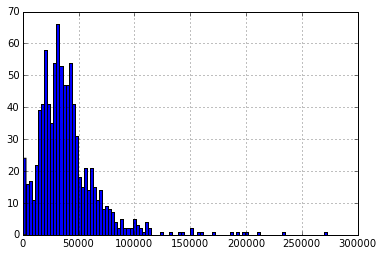

In [129]:
(pd.Series(survey_scenario.simulation.calculate_add('revdisp_mensuel_annuel'))[((u_c_ir - u_ir_a)<0)]).hist(bins = 100)

In [130]:
pay_irpp = (simulation.calculate('irpp') > 0)
print pay_irpp.shape
pd.value_counts(cast_array_from_entity_to_role(pay_irpp, 'foyer_fiscal', roles = [0]))

(52189,)


0    79012
1     1419
dtype: int64

In [131]:
decote_mensuel = simulation.calculate_add("decote_gain_fiscal_mensuel_times_12")/12
decote = simulation.calculate_add("decote_gain_fiscal")


has_decote_difference = (np.abs(decote -decote_mensuel)>0.1).astype(int)
has_decote_difference = cast_array_from_entity_to_role(has_decote_difference, 'foyer_fiscal', roles = [0])

nb_decote_diff_menage = sum_array_by_entity(has_decote_difference, 'menage')

print pd.value_counts(nb_decote_diff_menage)


utility_loss = (u_c_ir - u_ir_a)<-0.00000001
pd.value_counts(nb_decote_diff_menage[utility_loss])

#utility_loss = condition((u_c_ir - u_ir_a)<-0.00000001)
#utility_loss = cast_array_from_entity_to_role(utility_loss, roles = [0])


0    36663
1     5733
2      303
3       10
dtype: int64


/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:14: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index


2    42215
0      494
dtype: int64

In [132]:
revdisp_loss = (simulation.calculate_add('revdisp_mensuel_compensated_ir_mensuel') - simulation.calculate_add('revdisp_mensuel_annuel')) < -1
#no_decote_or_payment_threshold_concern =  
good_rev_trav = switch_entity('rfr', 'menage')/switch_entity('nbptr', 'menage') > 20000
pd.value_counts(pd.Series(revdisp_loss)[good_rev_trav])

False    9999
True      180
dtype: int64

In [133]:
dico = {} #bizare, qu'est-ce qu'il se passe exactement ?
a = 7
for month in range(1,13):
    dico[month] = zip(pd.Series(simulation.calculate("revdisp_mensuel_compensated_ir_mensuel", period = "2009-{}".format(month)))[good_rev_trav&revdisp_loss][a:a+1], 
                      pd.Series(simulation.calculate_add('revdisp_mensuel_compensated_ir_mensuel') - simulation.calculate_add('revdisp_mensuel_annuel'))[good_rev_trav&revdisp_loss][a:a+1],
                      pd.Series(switch_entity('irpp', 'famille'))[good_rev_trav&revdisp_loss][a:a+1],
                      
                     
                     )

/usr/local/lib/python2.7/site-packages/pandas/core/internals.py:179: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 48195 but corresponding boolean dimension is 42709
  return self.values[slicer]
/usr/local/lib/python2.7/site-packages/pandas/core/index.py:1087: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 48195 but corresponding boolean dimension is 42709
  result = getitem(key)


In [134]:
dico

{1: [(-0.0, -423.84424, -5130.47509765625)],
 2: [(-0.0, -423.84424, -5130.47509765625)],
 3: [(-0.0, -423.84424, -5130.47509765625)],
 4: [(-0.0, -423.84424, -5130.47509765625)],
 5: [(-0.0, -423.84424, -5130.47509765625)],
 6: [(-0.0, -423.84424, -5130.47509765625)],
 7: [(2231.2856, -423.84424, -5130.47509765625)],
 8: [(2231.2856, -423.84424, -5130.47509765625)],
 9: [(2231.2856, -423.84424, -5130.47509765625)],
 10: [(-0.0, -423.84424, -5130.47509765625)],
 11: [(-0.0, -423.84424, -5130.47509765625)],
 12: [(-0.0, -423.84424, -5130.47509765625)]}

In [135]:
good_rev_trav.shape

(42709,)

In [136]:
pd.Series(nb_decote_diff_menage.astype('bool'))[utility_loss == True].value_counts(normalize = True) #Parmis les ménages ayant eu une perte d'utilité 56% ont eu une différence de décote.

True     0.55668
False    0.44332
dtype: float64

In [137]:
pd.Series(nb_decote_diff_menage.astype('bool'))[utility_loss == True].value_counts(normalize = True) #Parmis les ménages ayant eu une perte d'utilité 56% ont eu une différence de décote.

True     0.55668
False    0.44332
dtype: float64

In [138]:
(nb_decote_diff_menage.astype('bool')*weight_menages.values).sum()/weight_menages.sum()

0.14083806022095235

In [139]:
nb_decote_diff_menage

array([ 2.,  0.,  0., ...,  0.,  0.,  0.])

In [140]:
pd.Series(utility_loss)[nb_decote_diff_menage.astype('bool')].value_counts(normalize = True) #Parmis les ménages ayant eu une différence de décote 5% ont eu une perte d'utilité

False    0.954515
True     0.045485
dtype: float64

In [141]:
pd.Series(nb_decote_diff_menage.astype('bool'))[utility_loss == True].value_counts()

True     275
False    219
dtype: int64

In [142]:
u_c_ir.shape

(42709,)

In [143]:
pd.value_counts(sum_array_by_entity(has_decote_difference, 'menage'))

0    36663
1     5733
2      303
3       10
dtype: int64

In [144]:
diff_decote_f = switch_array_entity(decote -decote_mensuel,"foyer_fiscal", "menage")

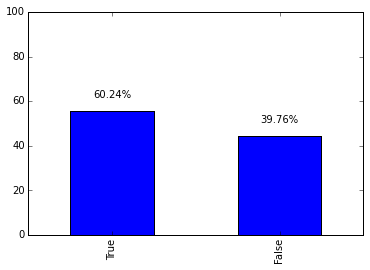

In [145]:
ax = ((pd.Series(np.abs(diff_decote_f)>0.1)[((u_c_ir - u_ir_a)<-0.00000001)]).value_counts( normalize = True)*100).plot(kind = "bar",)
plt.ylim((0,100))

labels = ["{}%".format(np.round(i,2)) for i in ((pd.Series(np.abs(diff_decote_f)>0.1)[((u_c_ir - u_ir_a)<-0.0000001)]).value_counts( normalize = True)*100) ] #0.000001 pour éviter les erreurs d'arrondis.
rects = ax.patches

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

In [146]:
survey_scenario.simulation.persons.count

80431

In [147]:
weight_menages.shape

(42709,)

In [148]:
is_decote_different = pd.Series(np.abs(diff_decote_f)>0.1)[((u_c_ir - u_ir_a)<-0.00000001)]

In [149]:
#TODO for famille and check if it coorrespond to the 46.43%
below_collection_thrshld = np.zeros(weight_foyers.shape[0], dtype=bool)
for month in range(1,13):
    irpp_mensuel = pd.Series(survey_scenario.simulation.calculate("irpp_mensuel", '2009-{}'.format(month)))
    below_collection_thrshld += (irpp_mensuel>1) & (irpp_mensuel<5.16)
    

In [150]:
pd.Series(below_collection_thrshld).value_counts()

False    51868
True       321
dtype: int64

In [151]:
np.array([True, False])+np.array([True, True])

array([ True,  True], dtype=bool)

In [152]:
#Qui sont les gagnants ? :


In [153]:
is_decote_different[is_decote_different==False]

216      False
234      False
413      False
853      False
993      False
1658     False
1771     False
1926     False
2154     False
2338     False
2380     False
2724     False
2778     False
2868     False
2978     False
3188     False
3201     False
3462     False
3918     False
4328     False
4506     False
4928     False
5202     False
5568     False
6122     False
6158     False
6352     False
6392     False
6429     False
6799     False
6904     False
6905     False
7102     False
7112     False
7120     False
7136     False
7291     False
7427     False
7910     False
7937     False
8134     False
8346     False
8436     False
8900     False
9354     False
9370     False
9423     False
10054    False
10127    False
10161    False
10492    False
10949    False
11015    False
11050    False
11254    False
11310    False
12128    False
12439    False
12539    False
13062    False
13182    False
13459    False
13547    False
13716    False
13761    False
13803    False
13811    F

In [154]:
pd.Series(np.abs(decote -decote_mensuel)>0.1)[((u_c_ir - u_ir_a)<0.000001)].value_counts(normalize = True)

IndexingError: Unalignable boolean Series key provided

In [ ]:
(pd.Series(decote!= decote_mensuel)[((u_c_ir - u_ir_a)<0)]).hist(bins = 100)

In [ ]:
revdisp[(u_c_ir>=u_ir_a)]

In [ ]:
print u_c_ir[(decote_annual==0) & (decote_monthly==0)].mean()
print u_ir_m[(decote_annual==0) & (decote_monthly==0)].mean()
print u_ir_a[(decote_annual==0) & (decote_monthly==0)].mean()

## Qui sont les gagnants ?

In [ ]:
print pd.value_counts((survey_scenario.simulation.calculate_add("revdisp_mensuel_annuel")-survey_scenario.simulation.calculate_add("revdisp_mensuel_ir_mensuel"))>1)
print pd.value_counts((survey_scenario.simulation.calculate_add("revdisp_mensuel_annuel")-survey_scenario.simulation.calculate_add("revdisp_mensuel_ir_mensuel"))<-1)

In [ ]:
print pd.Series(((survey_scenario.simulation.calculate_add("revdisp_mensuel_annuel")-survey_scenario.simulation.calculate_add("revdisp_mensuel_ir_mensuel"))>1)
                     *weight_menages).sum()
print pd.Series(((survey_scenario.simulation.calculate_add("revdisp_mensuel_annuel")-survey_scenario.simulation.calculate_add("revdisp_mensuel_ir_mensuel"))<-1)
                      *weight_menages).sum()

In [ ]:
np.mean(
    (survey_scenario.simulation.calculate("rbg")/survey_scenario.simulation.calculate("nbptr"))\
    [survey_scenario.simulation.calculate_add("irpp")-survey_scenario.simulation.calculate_add("irpp_mensuel")>1]
    )

In [ ]:
plt.figure(figsize=(15,10))
plt.hist(    (survey_scenario.simulation.calculate("rbg")/survey_scenario.simulation.calculate("nbptr"))\
    [survey_scenario.simulation.calculate_add("irpp")-survey_scenario.simulation.calculate_add("irpp_mensuel")>1], bins = 200, label = "Paying less on monthly basis")
plt.hist(    (survey_scenario.simulation.calculate("rbg")/survey_scenario.simulation.calculate("nbptr"))\
    [survey_scenario.simulation.calculate_add("irpp")-survey_scenario.simulation.calculate_add("irpp_mensuel")<-1], bins = 65, color= 'r', label = "Paying more on monthly basis")
plt.xlim(0,50000)
plt.title("paying more or less")

###### Weighted

In [ ]:
from openfisca_utils import make_ready_to_use_simulation
from openfisca_core import rates
simulation = make_ready_to_use_simulation.make_ready_to_use_simulation(2009,False)
rbg_test_case = simulation.calculate('rbg')
irpp_test_case = simulation.calculate('irpp')
marginal_rate = rates.marginal_rate(irpp_test_case, rbg_test_case)-1
to_change = pd.Series(marginal_rate)[marginal_rate>1].index
#to_change = pd.Series(rates.marginal_rate(irpp_test_case, rbg_test_case)-1)[rates.marginal_rate(irpp_test_case, rbg_test_case)-1>1].index
marginal_rate[to_change] = marginal_rate[to_change+1]
plt.plot(marginal_rate)

In [ ]:
to_change = pd.Series(rates.marginal_rate(irpp_test_case, rbg_test_case)-1)[rates.marginal_rate(irpp_test_case, rbg_test_case)-1>1].index


In [ ]:
pd.Series(marginal_rate)[marginal_rate>1]

In [ ]:
np.mean(survey_scenario.simulation.calculate("rbg"))

In [ ]:
np.array([True,True,False]) *np.array([2,3,4])

In [ ]:
pd.value_counts((survey_scenario.simulation.calculate_add("revdisp_mensuel_annuel") - survey_scenario.simulation.calculate_add("revdisp_mensuel_compensated_ir_mensuel")>1))

In [ ]:


weights1 = weight_foyers[survey_scenario.simulation.calculate_add("irpp")-survey_scenario.simulation.calculate_add("irpp_mensuel")>1]
weights2 = weight_foyers[survey_scenario.simulation.calculate_add("irpp")-survey_scenario.simulation.calculate_add("irpp_mensuel")<-1]

fig, ax1 = plt.subplots(figsize=(20, 10))


ax1.hist(    (survey_scenario.simulation.calculate("rbg")/survey_scenario.simulation.calculate("nbptr"))\
    [(survey_scenario.simulation.calculate_add("irpp")-survey_scenario.simulation.calculate_add("irpp_mensuel"))>1], bins = 400, label = "Paying more on monthly basis", weights= weights1)
ax1.hist(    (survey_scenario.simulation.calculate("rbg")/survey_scenario.simulation.calculate("nbptr"))\
    [(survey_scenario.simulation.calculate_add("irpp")-survey_scenario.simulation.calculate_add("irpp_mensuel"))<-1], bins = 130, color= 'r', label = "Paying less on monthly basis",weights= weights2)


ax1.set_xlim(0,50000)
ax2 = plt.twinx()
ax2.plot(rbg_test_case[1:],marginal_rate, 'k', label = "marginal tax rate")
ax2.set_xlim(0,50000)
ax2.legend()
ax1.legend(bbox_to_anchor=(0.22, 1))
ax1.grid(which = 'both')
ax1.text(11000,500000, u"minimum wage", weight = 'bold',)
ax2.set_ylabel("marginal tax rate")
ax1.set_xlabel("Gross global income divided by fiscal shares")
ax1.set_ylabel("number of taxunit")
#plt.title("")


In [ ]:
-(100 -  110)

In [ ]:
survey_scenario.simulation.calculate_add("irpp_mensuel").mean()

### Gains monetaires

#### Same annalysis with benefits

In [ ]:
survey_scenario.compute_aggregate("rsa_socle_majore_mensualise")

In [ ]:
survey_scenario.compute_aggregate("rsa_non_majore")

In [ ]:
pd.Series(survey_scenario.simulation.calculate("rsa_eligibilite_tns", "2009-01")).value_counts()

# Utilitarian monetary gains

In [ ]:
monetary_gain_ir = np.zeros(weight_menages.shape[0])
for month in range(1,10):
    monetary_gain_ir += (
    survey_scenario.simulation.calculate("inverted_utility_compensated_ir_mensuel", "2009") - 
    survey_scenario.simulation.calculate("inverted_utility_ir_annuel", "2009")
    )*weight_menages

In [ ]:
((monetary_gain_ir.sum(0)/10)*12)/10**9

Gains moyens par ménages.

In [ ]:
monetary_gain_ir = pd.Series(monetary_gain_ir)
monetary_gains_ir_0 = monetary_gain_ir[monetary_gain_ir != 0]
monetary_gains_ir_0.hist(bins = 500, weights = (pd.Series(weight_menages)[monetary_gain_ir != 0]).values)
plt.xlim(-10000,10000)

In [ ]:
print pd.Series(monetary_gain_ir<-10).value_counts()
print pd.Series(monetary_gain_ir>10).value_counts()
pd.Series(monetary_gain_ir)[monetary_gain_ir>10].shape

In [ ]:
month = 7
gain = pd.Series(survey_scenario.simulation.calculate("inverted_utility_compensated_ir_mensuel", "2009") - 
    survey_scenario.simulation.calculate("inverted_utility_ir_annuel", "2009")
    )
gain[np.abs(gain)>1].mean()


In [ ]:
 diff_in_income = pd.Series(
    np.abs(survey_scenario.simulation.calculate("revdisp_mensuel_annuel", "2009-{}".format(month))
          - survey_scenario.simulation.calculate("revdisp_mensuel_compensated_ir_mensuel", "2009-{}".format(month)))>1
    )

In [ ]:
weight_menages.sum(0)

In [ ]:
#monetary_gain.sum(0)/10**9

#### Non compensated

In [ ]:
for month in range(1,13):
    gain_u = (pd.Series(
     survey_scenario.simulation.calculate("utility_ir_mensuel", "2009") - 
survey_scenario.simulation.calculate("utility_ir_annuel", "2009")
        ))
    gain_m =  (
        survey_scenario.simulation.calculate("inverted_utility_compensated_ir_mensuel", "2009") - 
        survey_scenario.simulation.calculate("inverted_utility_ir_annuel", "2009"))
    pd.DataFrame({'gain_utilite':gain_u, 'gain_argent':gain_m})
    plt.figure()
    pd.Series(gain_m)[gain_m!=0].hist(bins = 1500)
    plt.xlim(-200,200)
    plt.xlabel("equivalent monetary gains in euros ")
    plt.ylabel('frequency')

In [ ]:
u_monetary_gain_ir = np.zeros(weight_menages.shape[0])
for month in range(1,10):
    u_monetary_gain_ir += (
    survey_scenario.simulation.calculate("inverted_utility_ir_mensuel", "2009") - 
    survey_scenario.simulation.calculate("inverted_utility_ir_annuel", "2009")
    )*weight_menages

In [ ]:
((u_monetary_gain_ir.sum(0)/10)*12)/10**9

In [ ]:
u_monetary_gain_ir = np.zeros(weight_menages.shape[0])
for month in range(1,10):
    u_monetary_gain_ir += np.mean(
    (survey_scenario.simulation.calculate("inverted_utility_ir_mensuel", "2009") - 
    survey_scenario.simulation.calculate("inverted_utility_ir_annuel", "2009"))*weight_menages
    )

In [ ]:
((u_monetary_gain_ir.sum(0)/10)*12)/10**9

In [ ]:
u_monetary_gain_ir = np.zeros(weight_menages.shape[0])
for month in range(1,12):
    u_monetary_gain_ir += (
    survey_scenario.simulation.calculate("inverted_utility_ir_mensuel", "2009") - 
    survey_scenario.simulation.calculate("inverted_utility_ir_annuel", "2009")
    )*weight_menages

In [ ]:
(u_monetary_gain_ir.sum(0))/10**9

In [ ]:
month = 6
gain = pd.Series(survey_scenario.simulation.calculate("inverted_utility_ir_mensuel", "2009") - 
    survey_scenario.simulation.calculate("inverted_utility_ir_annuel", "2009")
    )
mean_gain = gain[np.abs(gain)>1].mean()
print('{} gain on average'.format(mean_gain))

In [ ]:
u_monetary_gain = np.zeros(weight_menages.shape[0])
for month in range(1,10):
    u_monetary_gain +=np.mean(
        pd.Series(survey_scenario.simulation.calculate("inverted_utility_compensated_ir_mensuel", "2009") - 
        survey_scenario.simulation.calculate("inverted_utility_ir_annuel", "2009"))
               )
(((u_monetary_gain_ir/10)*12)/10**9).mean()  

#### mean monetary equivalent utility gain for each month

In [ ]:
u_money_gain = np.zeros(weight_menages.shape[0])
mean_gain = np.zeros(1)
for month in range(1,13):
    u_money_gain = pd.Series(survey_scenario.simulation.calculate("inverted_utility_ir_mensuel", "2009") - 
        survey_scenario.simulation.calculate("inverted_utility_ir_annuel", "2009")
        )
    mean_gain += (u_money_gain[np.abs(u_money_gain)>1]).mean()
print('{} gain on average'.format(mean_gain[0]))

#### mean monetary equivalent utility gain over the year

In [ ]:
u_annuelle = pd.Series(np.zeros(weight_menages.shape[0]))
u_mensuelle = pd.Series(np.zeros(weight_menages.shape[0]))
mean_gain = np.zeros(1)
for month in range(1,13):
    u_annuelle += pd.Series(
        survey_scenario.simulation.calculate("utility_ir_annuel", "2009-{}".format(month))
        )
    u_mensuelle += pd.Series(survey_scenario.simulation.calculate("utility_ir_mensuel", "2009-{}".format(month)) 
        )
eq_money_u_annuelle = np.exp((np.log(-u_annuelle))/-.87)
eq_money_u_mensuelle = np.exp((np.log(-u_mensuelle))/-.87)
impact_filter = (u_annuelle != u_mensuelle)

print('{} gain on average'.format(eq_money_u_mensuelle.mean() - eq_money_u_annuelle.mean()))
print('{} gain on average for concerned taxunits'.format(eq_money_u_mensuelle[impact_filter].mean() - eq_money_u_annuelle[impact_filter].mean()))

#### Compensated

In [ ]:
for month in range(1,13):
    gain_u = (pd.Series(
     survey_scenario.simulation.calculate("utility_compensated_ir_mensuel", "2009") - 
survey_scenario.simulation.calculate("utility_ir_annuel", "2009")
        ))
    gain_m =  (
        survey_scenario.simulation.calculate("inverted_utility_compensated_ir_mensuel", "2009") - 
        survey_scenario.simulation.calculate("inverted_utility_ir_annuel", "2009"))
    pd.DataFrame({'gain_utilite':gain_u, 'gain_argent':gain_m})
    plt.figure()
    pd.Series(gain_m)[gain_m!=0].hist(bins = 1500)
    plt.xlim(-200,200)
    plt.xlabel("equivalent monetary gains in euros ")
    plt.ylabel('frequency')
#TODO: problème sur les 3 derniers mois !

In [ ]:
u_monetary_gain_ir = np.zeros(weight_menages.shape[0])
for month in range(1,10):
    u_monetary_gain_ir += (
    survey_scenario.simulation.calculate("utility_compensated_ir_mensuel", "2009") - 
    survey_scenario.simulation.calculate("inverted_utility_ir_annuel", "2009")
    )*weight_menages

In [ ]:
((u_monetary_gain_ir.sum(0)/10)*12)/10**9

In [ ]:
u_monetary_gain_ir = np.zeros(weight_menages.shape[0])
for month in range(1,10):
    u_monetary_gain_ir += np.mean(
    (survey_scenario.simulation.calculate("utility_compensated_ir_mensuel", "2009") - 
    survey_scenario.simulation.calculate("inverted_utility_ir_annuel", "2009"))*weight_menages
    )

In [ ]:
((u_monetary_gain_ir.sum(0)/10)*12)/10**9

In [ ]:
month = 7
gain = pd.Series(survey_scenario.simulation.calculate("inverted_utility_compensated_ir_mensuel", "2009") - 
    survey_scenario.simulation.calculate("inverted_utility_ir_annuel", "2009")
    )
mean_gain = gain[np.abs(gain)>1].mean()
print('{} gain on average'.format(mean_gain))

In [ ]:
u_monetary_gain = np.zeros(weight_menages.shape[0])
for month in range(1,10):
    u_monetary_gain +=np.mean(
        pd.Series(survey_scenario.simulation.calculate("inverted_utility_compensated_ir_mensuel", "2009") - 
        survey_scenario.simulation.calculate("inverted_utility_ir_annuel", "2009"))
               )
(((u_monetary_gain_ir/10)*12)/10**9).mean()  

#### mean monetary equivalent utility gain over the year

In [ ]:
u_annuelle = pd.Series(np.zeros(weight_menages.shape[0]))
u_mensuelle = pd.Series(np.zeros(weight_menages.shape[0]))
mean_gain = np.zeros(1)
for month in range(1,13):
    u_annuelle += pd.Series(
        survey_scenario.simulation.calculate("utility_ir_annuel", "2009-{}".format(month))
        )
    u_mensuelle += pd.Series(survey_scenario.simulation.calculate("utility_compensated_ir_mensuel", "2009-{}".format(month)) 
        )
eq_money_u_annuelle = np.exp((np.log(-u_annuelle))/-.87)
eq_money_u_mensuelle = np.exp((np.log(-u_mensuelle))/-.87)
impact_filter = (u_annuelle != u_mensuelle)

print('{} gain on average'.format(eq_money_u_mensuelle.mean() - eq_money_u_annuelle.mean()))
print('{} gain on average for concerned taxunits'.format(eq_money_u_mensuelle[impact_filter].mean() - eq_money_u_annuelle[impact_filter].mean()))


In [ ]:
u_annuelle = pd.Series(np.zeros(weight_menages.shape[0]))
u_mensuelle = pd.Series(np.zeros(weight_menages.shape[0]))
mean_gain = np.zeros(1)
for month in range(1,13):
    u_annuelle += pd.Series(
        survey_scenario.simulation.calculate("utility_ir_annuel", "2009-{}".format(month))
        )
    u_mensuelle += pd.Series(survey_scenario.simulation.calculate("utility_ir_mensuel_rsa_mensuel", "2009-{}".format(month)) 
        )
eq_money_u_annuelle = np.exp((np.log(-u_annuelle))/-.87)
eq_money_u_mensuelle = np.exp((np.log(-u_mensuelle))/-.87)
impact_filter = (u_annuelle != u_mensuelle)

print('{} gain on average'.format(eq_money_u_mensuelle.mean() - eq_money_u_annuelle.mean()))
print('{} gain on average for concerned taxunits'.format(eq_money_u_mensuelle[impact_filter].mean() - eq_money_u_annuelle[impact_filter].mean()))


In [ ]:
u_mensuelle

### RSA+IR

In [ ]:
for month in range(1,13):
    gain_u = (pd.Series(
     survey_scenario.simulation.calculate("utility_ir_mensuel_rsa_mensuel", "2009") - 
survey_scenario.simulation.calculate("utility_ir_annuel", "2009")
        ))
    gain_m =  (
        survey_scenario.simulation.calculate("inverted_utility_compensated_ir_mensuel_rsa_mensuel", "2009") - 
        survey_scenario.simulation.calculate("inverted_utility_ir_annuel", "2009"))
    pd.DataFrame({'gain_utilite':gain_u, 'gain_argent':gain_m})
    plt.figure()
    pd.Series(gain_m)[gain_m!=0].hist(bins = 1500)
    plt.xlim(-200,200)
    plt.xlabel("equivalent monetary gains in euros ")
    plt.ylabel('frequency')
#TODO: problème sur les 3 derniers mois !

In [ ]:
monetary_gain_ir_rsa = np.zeros(weight_menages.shape[0])
for month in range(1,10):
    monetary_gain_ir_rsa += (
    survey_scenario.simulation.calculate("inverted_utility_compenstaed_ir_mensuel_rsa_mensuel", "2009-{}".format(month)) - 
    survey_scenario.simulation.calculate("inverted_utility_ir_annuel", "2009-{}".format(month))
    )*weight_menages

In [ ]:
((monetary_gain_ir_rsa.sum(0)/10)*12)/10**9

## Gains et perte passage à la retraite.

In [ ]:
print survey_scenario.simulation.persons.simulation.entity_by_key_plural

In [ ]:
coucou.entity.simulation

In [ ]:
c = np.zeros(1)
a = np.array([1,2,3])
b = np.array([True,True,False])
c += a[b]; c

In [ ]:
is_retired = np.zeros(weight_individus.shape[0])
is_active = np.zeros(weight_individus.shape[0])
is_inactive = np.zeros(weight_individus.shape[0])
for month in range(1,13):
    is_retired += survey_scenario.simulation.calculate("retraite_imposable", "2009-{}".format(month))>0
    is_active += survey_scenario.simulation.calculate("salaire_imposable", "2009-{}".format(month))>0
    is_inactive += (survey_scenario.simulation.calculate("salaire_imposable", "2009-{}".format(month)) + survey_scenario.simulation.calculate("retraite_imposable", "2009-{}".format(month))) == 0

In [ ]:
(pd.Series(is_retired + is_active + is_inactive).hist(bins= 12))

In [ ]:
is_retired = np.zeros(weight_individus.shape[0])
is_active = np.zeros(weight_individus.shape[0])
is_inactive = np.zeros(weight_individus.shape[0])
is_retire_active = np.zeros(weight_individus.shape[0])

for month in range(1,13):
    retraite_imposable = survey_scenario.simulation.compute("retraite_imposable", "2009-{}".format(month))
    salaire_imposable = survey_scenario.simulation.compute("salaire_imposable", "2009-{}".format(month))
    is_retired += retraite_imposable.array >0
    is_active += salaire_imposable.array > 0 
    is_retire_active += (retraite_imposable.array >0) & (salaire_imposable.array > 0 )
    is_inactive += (retraite_imposable.array == 0) & (salaire_imposable.array == 0 )
    

In [ ]:
is_retire_is_active_not_retire_active = ((is_retire_active == 0)
                                         & (is_active>0)
                                         & (is_inactive >0)
                                         )

In [ ]:
survey_scenario.simulation.tax_benefit_system.Variable.formula_class.sum_by_entity(retraite_imposable)

In [ ]:
survey_scenario.simulation.tax_benefit_system.Variable.formula_class.sum_by_entity('h')

In [ ]:
 type(class_name.encode('utf-8'), (Reform.DatedVariable,), definitions_by_name)

In [ ]:
pd.Series(is_retire_is_active_not_retire_active).value_counts()

In [ ]:
(pd.Series(is_retired + is_active + is_inactive)).value_counts()

In [ ]:
passage_a_la_retraite = pd.Series(is_retired) & pd.Series(is_not_retired)

## Revdisp over the year

## Annual IR Basis

In [155]:
revdisp_oy = pd.DataFrame()
temp = pd.DataFrame()
for month in range(1,13):
    for var in ['salaire_imposable', 'chomage_imposable', 'pen_mensuel', 'psoc_mensuel', 'ppe']:
        temp[var] = pd.Series(np.sum(survey_scenario.simulation.calculate(var, "2009-{}".format(month))))
    temp['impo'] = pd.Series(np.sum(survey_scenario.simulation.calculate('impo', "2009".format(month))))/12
    temp['rev_cap'] = pd.Series(np.sum(survey_scenario.simulation.calculate('rev_cap', "2009".format(month))))/12
    revdisp_oy = revdisp_oy.append(temp, ignore_index=True)
revdisp_oy.index = range(1,13)
revdisp_oy

,salaire_imposable,chomage_imposable,pen_mensuel,psoc_mensuel,ppe,impo,rev_cap
1,71416512,3656479.00,29897146,4056912.00,318146.9375,-7299702,128487.666667
2,70688920,3469458.50,27559848,4193110.75,318146.9375,-7299702,128487.666667
3,70450472,3365968.00,26859818,4266371.50,318146.9375,-7299702,128487.666667
4,70135936,3326189.00,26358846,6316693.00,318146.9375,-7299702,128487.666667
5,69998968,3300592.25,25910714,4551360.00,318146.9375,-7299702,128487.666667
6,69905648,3298131.75,25603592,4552602.00,318146.9375,-7299702,128487.666667
7,69791208,3538836.00,25857964,4581355.00,318146.9375,-7299702,128487.666667
8,69448208,3591816.75,25690658,4592786.00,318146.9375,-7299702,128487.666667
9,69645208,3441578.50,25508292,4628562.50,318146.9375,-7299702,128487.666667
10,69467056,3380218.25,25326802,4593617.00,318146.9375,-7299702,128487.666667


#### With weight

In [156]:
revdisp_oy = pd.DataFrame()
temp = pd.DataFrame()
for month in range(1,13):
    for var in ['salaire_imposable', 'chomage_imposable', 'pen_mensuel',]:
        temp[var] = pd.Series(np.sum(survey_scenario.simulation.calculate(var, "2009-{}".format(month))* weight_individus))
    for var in ['psoc_mensuel']:
        temp[var] = pd.Series(np.sum(survey_scenario.simulation.calculate(var, "2009-{}".format(month))* weight_familles))      
    temp['impo'] = pd.Series(np.sum(survey_scenario.simulation.calculate('impo', "2009".format(month))* weight_menages))/12
    temp['rev_cap'] = pd.Series(np.sum(survey_scenario.simulation.calculate('rev_cap', "2009".format(month))))/12
    revdisp_oy = revdisp_oy.append(temp, ignore_index=True)
    

revdisp_oy.index = range(1,13)
revdisp_oy/10**9

,salaire_imposable,chomage_imposable,pen_mensuel,psoc_mensuel,impo,rev_cap
1,39.201943,2.013111,13.549163,2.078402,-3.846594,0.000128
2,38.824554,1.908554,12.388445,2.163502,-3.846594,0.000128
3,38.710860,1.831814,12.061467,2.204605,-3.846594,0.000128
4,38.538875,1.822529,11.867922,3.311033,-3.846594,0.000128
5,38.493414,1.815278,11.673823,2.355001,-3.846594,0.000128
6,38.472104,1.825492,11.542160,2.357968,-3.846594,0.000128
7,38.367678,1.986160,11.712438,2.376611,-3.846594,0.000128
8,38.210997,2.004255,11.615666,2.373855,-3.846594,0.000128
9,38.294070,1.906487,11.517676,2.393209,-3.846594,0.000128
10,38.193556,1.886871,11.439066,2.375327,-3.846594,0.000128


In [157]:
print (revdisp_oy/10**9).to_latex()

\begin{tabular}{lrrrrrr}
\toprule
{} &  salaire\_imposable &  chomage\_imposable &  pen\_mensuel &  psoc\_mensuel &      impo &   rev\_cap \\
\midrule
1  &          39.201943 &           2.013111 &    13.549163 &      2.078402 & -3.846594 &  0.000128 \\
2  &          38.824554 &           1.908554 &    12.388445 &      2.163502 & -3.846594 &  0.000128 \\
3  &          38.710860 &           1.831814 &    12.061467 &      2.204605 & -3.846594 &  0.000128 \\
4  &          38.538875 &           1.822529 &    11.867922 &      3.311033 & -3.846594 &  0.000128 \\
5  &          38.493414 &           1.815278 &    11.673823 &      2.355001 & -3.846594 &  0.000128 \\
6  &          38.472104 &           1.825492 &    11.542160 &      2.357968 & -3.846594 &  0.000128 \\
7  &          38.367678 &           1.986160 &    11.712438 &      2.376611 & -3.846594 &  0.000128 \\
8  &          38.210997 &           2.004255 &    11.615666 &      2.373855 & -3.846594 &  0.000128 \\
9  &          38.294070 &

/usr/local/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/usr/local/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


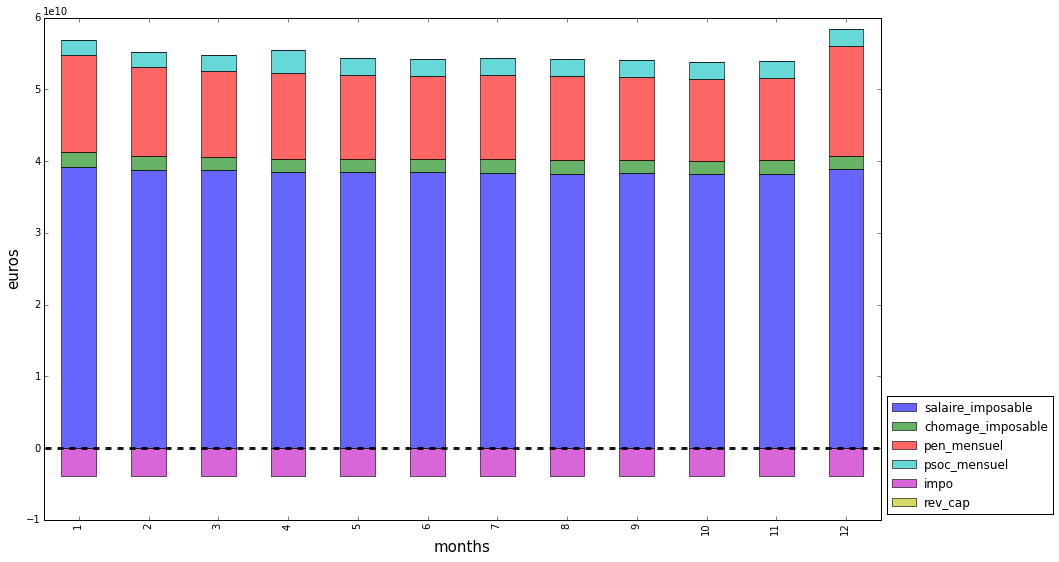

In [158]:
ax = revdisp_oy.plot(kind = 'bar', stacked = 'True',alpha = 0.6, figsize=(15,9) )
#ax = fig.add_subplot(111)

plt.hlines(0,-1,13, linestyles='dashed', linewidth = 3, alpha = 0.9)

plt.xlabel("months", fontsize = 15)
plt.ylabel("euros", fontsize = 15)
plt.legend( bbox_to_anchor=(1, 0, 1, 1), loc=3,)
plt.savefig("image_result_of_mensualisation/revdisp_ir_annual.png")

## Monthly Basis

In [ ]:
revdisp_oy = pd.DataFrame()
temp = pd.DataFrame()
for month in range(1,13):
    for var in ['salaire_imposable', 'chomage_imposable', 'pen_mensuel', 'psoc_mensuel', 'ppe']:
        temp[var] = pd.Series(np.sum(survey_scenario.simulation.calculate(var, "2009-{}".format(month))))
    temp['impo_mensuel'] = pd.Series(np.sum(survey_scenario.simulation.calculate('impo_mensuel', "2009-{}".format(month))))
    temp['rev_cap'] = pd.Series(np.sum(survey_scenario.simulation.calculate('rev_cap', "2009".format(month))))/12
    revdisp_oy = revdisp_oy.append(temp, ignore_index=True)
revdisp_oy.index = range(1,13)
revdisp_oy

### With weight

In [ ]:
revdisp_oy = pd.DataFrame()
temp = pd.DataFrame()
for month in range(1,13):
    for var in ['salaire_imposable', 'chomage_imposable', 'pen_mensuel']:
        temp[var] = pd.Series(np.sum(survey_scenario.simulation.calculate(var, "2009-{}".format(month))* weight_individus))
    for var in ['psoc_mensuel']:
        temp[var] = pd.Series(np.sum(survey_scenario.simulation.calculate(var, "2009-{}".format(month))* weight_familles))      
    temp['impo_mensuel'] = pd.Series(np.sum(survey_scenario.simulation.calculate('impo_mensuel', "2009-{}".format(month))* weight_menages))
    temp['rev_cap'] = pd.Series(np.sum(survey_scenario.simulation.calculate('rev_cap', "2009".format(month))*weight_individus))/12
    revdisp_oy = revdisp_oy.append(temp, ignore_index=True)

revdisp_oy.index = range(1,13)
revdisp_oy/10**9

In [ ]:
ax = revdisp_oy.plot(kind = 'bar', stacked = 'True',alpha = 0.6, figsize=(15,9) )
#ax = fig.add_subplot(111)

plt.hlines(0,-1,13, linestyles='dashed', linewidth = 3, alpha = 0.9)

plt.xlabel("months", fontsize = 15)
plt.ylabel("euros", fontsize = 15)
plt.legend( bbox_to_anchor=(1, 0, 1, 1), loc=3,)
plt.savefig("image_result_of_mensualisation/revdisp_ir_monthly.png")

In [ ]:
revdisp_oy['total'] = revdisp_oy.sum(1)
print (revdisp_oy/10**9).to_latex()

## Compensated Monthly Basis

In [ ]:
revdisp_oy = pd.DataFrame()
temp = pd.DataFrame()
for month in range(1,13):
    for var in ['salaire_imposable', 'chomage_imposable', 'pen_mensuel', 'psoc_mensuel', 'ppe']:
        temp[var] = pd.Series(np.sum(survey_scenario.simulation.calculate(var, "2009-{}".format(month))))
    temp['impo_mensuel'] = pd.Series(np.sum(survey_scenario.simulation.calculate('compensated_impo_mensuel', "2009-{}".format(month))))
    temp['rev_cap'] = pd.Series(np.sum(survey_scenario.simulation.calculate('rev_cap', "2009".format(month))))/12
    revdisp_oy = revdisp_oy.append(temp, ignore_index=True)
revdisp_oy.index = range(1,13)
revdisp_oy

### With weight

In [ ]:
revdisp_oy = pd.DataFrame()
temp = pd.DataFrame()
for month in range(1,13):
    for var in ['salaire_imposable', 'chomage_imposable', 'pen_mensuel']:
        temp[var] = pd.Series(np.sum(survey_scenario.simulation.calculate(var, "2009-{}".format(month))* weight_individus))
    for var in ['psoc_mensuel']:
        temp[var] = pd.Series(np.sum(survey_scenario.simulation.calculate(var, "2009-{}".format(month))* weight_familles))      
    temp['impo_mensuel'] = pd.Series(np.sum(survey_scenario.simulation.calculate('compensated_impo_mensuel', "2009-{}".format(month))* weight_menages))
    temp['rev_cap'] = pd.Series(np.sum(survey_scenario.simulation.calculate('rev_cap', "2009".format(month))*weight_individus))/12
    revdisp_oy = revdisp_oy.append(temp, ignore_index=True)
revdisp_oy.index = range(1,13)
revdisp_oy/10**9

In [ ]:
ax = revdisp_oy.plot(kind = 'bar', stacked = 'True',alpha = 0.6, figsize=(15,9) )
#ax = fig.add_subplot(111)

plt.hlines(0,-1,13, linestyles='dashed', linewidth = 3, alpha = 0.9)

plt.xlabel("months", fontsize = 15)
plt.ylabel("euros", fontsize = 15)
plt.legend( bbox_to_anchor=(1, 0, 1, 1), loc=3,)
plt.savefig("image_result_of_mensualisation/revdisp_ir_comp_monthly.png")

In [ ]:
revdisp_oy['total'] = revdisp_oy.sum(1)
print (revdisp_oy/10**9).to_latex()

## Compensated Rsa monthly

In [ ]:
revdisp_oy = pd.DataFrame()
temp = pd.DataFrame()
for month in range(1,13):
    for var in ['salaire_imposable', 'chomage_imposable', 'pen_mensuel', 'psoc_mensuel_rsa_mensuel', 'ppe']:
        temp[var] = pd.Series(np.sum(survey_scenario.simulation.calculate(var, "2009-{}".format(month))))
    temp['impo_mensuel'] = pd.Series(np.sum(survey_scenario.simulation.calculate('compensated_impo_mensuel', "2009-{}".format(month))))
    temp['rev_cap'] = pd.Series(np.sum(survey_scenario.simulation.calculate('rev_cap', "2009".format(month))))/12
    revdisp_oy = revdisp_oy.append(temp, ignore_index=True)
revdisp_oy.index = range(1,13)
revdisp_oy

### With weight

In [ ]:
revdisp_oy = pd.DataFrame()
temp = pd.DataFrame()
for month in range(1,13):
    for var in ['salaire_imposable', 'chomage_imposable', 'pen_mensuel']:
        temp[var] = pd.Series(np.sum(survey_scenario.simulation.calculate(var, "2009-{}".format(month))* weight_individus))
    for var in ['psoc_mensuel_rsa_mensuel']:
        temp[var] = pd.Series(np.sum(survey_scenario.simulation.calculate(var, "2009-{}".format(month))* weight_familles))      
    temp['impo_mensuel'] = pd.Series(np.sum(survey_scenario.simulation.calculate('compensated_impo_mensuel', "2009-{}".format(month))* weight_menages))
    temp['rev_cap'] = pd.Series(np.sum(survey_scenario.simulation.calculate('rev_cap', "2009".format(month))*weight_individus))/12
    revdisp_oy = revdisp_oy.append(temp, ignore_index=True)
revdisp_oy.index = range(1,13)
revdisp_oy/10**9

In [ ]:
ax = revdisp_oy.plot(kind = 'bar', stacked = 'True',alpha = 0.6, figsize=(15,9) )
#ax = fig.add_subplot(111)

plt.hlines(0,-1,13, linestyles='dashed', linewidth = 3, alpha = 0.9)

plt.xlabel("months", fontsize = 15)
plt.ylabel("euros", fontsize = 15)
plt.legend( bbox_to_anchor=(1, 0, 1, 1), loc=3,)
plt.savefig("image_result_of_mensualisation/revdisp_rsa_ir_comp_monthly.png")

In [ ]:
revdisp_oy['total'] = revdisp_oy.sum(1)
print (revdisp_oy/10**9).to_latex()

In [ ]:
revdisp_oy = pd.DataFrame()
temp = pd.DataFrame()
for month in range(1,13):
    for var in ['rev_trav_mensuel', 'pen_mensuel', 'chomage_imposable', 'pen_mensuel', 'ppe']:
        temp[var] = pd.Series(np.sum(survey_scenario.simulation.calculate(var, "2009-{}".format(month))))
    temp['psoc_mensuel'] = - pd.Series(np.sum(survey_scenario.simulation.calculate('psoc_mensuel', "2009-{}".format(month))))
    temp['impo'] = pd.Series(np.sum(survey_scenario.simulation.calculate('impo', "2009".format(month))))/12
    revdisp_oy = revdisp_oy.append(temp, ignore_index=True)
revdisp_oy.index = range(1,13)
revdisp_oy

In [ ]:

undecompsed_revdisp = pd.DataFrame()
temp = pd.DataFrame()
for month in range(1,13):
    temp['revdisp_mensuel_annuel'] = pd.Series(np.sum(survey_scenario.simulation.calculate('revdisp_mensuel_annuel', "2009-{}".format(month))))
    undecompsed_revdisp = undecompsed_revdisp.append(temp, ignore_index=True)
    

In [ ]:
undecompsed_revdisp.index = range(1,13)

In [ ]:
df1 = pd.DataFrame({'revdisp_mensuel_annuel':revdisp_oy.sum(1).values}) 
df1.index = range(1,13)
(df1 - undecompsed_revdisp)/10**9

In [ ]:
undecompsed_revdisp.index = np.arange(-0.5,11.5,1)

In [ ]:
undecompsed_revdisp.index = np.arange(-0.5,11.5, 1) #TODO: pouruoi une différence ?
ax = revdisp_oy.plot(kind = 'bar', stacked = 'True',alpha = 0.2, figsize=(15,9) )
#ax = fig.add_subplot(111)
plt.bar(undecompsed_revdisp.index, undecompsed_revdisp.values, color = 'k', alpha = 0.4)
plt.hlines(0,-1,13, linestyles='dashed', linewidth = 3, alpha = 0.5)

plt.xlabel("months", fontsize = 15)
plt.ylabel("headcount", fontsize = 15)
plt.legend( bbox_to_anchor=(1, 0, 1, 1), loc=3,)

In [ ]:
undecompsed_revdisp.index = np.arange(-0.5,11.5, 1) #TODO: pouruoi une différence ?
ax = revdisp_oy.plot(kind = 'bar', stacked = 'True',alpha = 0.6, figsize=(15,9) )
#ax = fig.add_subplot(111)

plt.hlines(0,-1,13, linestyles='dashed', linewidth = 3, alpha = 0.9)

plt.xlabel("months", fontsize = 15)
plt.ylabel("headcount", fontsize = 15)
plt.legend( bbox_to_anchor=(1, 0, 1, 1), loc=3,)

In [ ]:
undecompsed_revdisp


## Monthly IR basis 

In [ ]:
revdisp_oy = pd.DataFrame()
temp = pd.DataFrame()
for month in range(1,13):
    for var in ['salaire_imposable', 'chomage_imposable', 'pen_mensuel', 'psoc_mensuel', 'ppe', 'impo_mensuel']:
        temp[var] = pd.Series(np.sum(survey_scenario.simulation.calculate(var, "2009-{}".format(month))))
        temp['psoc_mensuel'] = - pd.Series(np.sum(survey_scenario.simulation.calculate('psoc_mensuel', "2009-{}".format(month))))
    revdisp_oy = revdisp_oy.append(temp, ignore_index=True)
revdisp_oy.index = range(1,13)
revdisp_oy
revdisp_oy.plot(kind = 'bar', stacked = 'True', figsize=(15,9) )
plt.hlines(0,-1,13, linestyles='dashed', linewidth = 3, alpha = 0.5)
plt.xlabel("months", fontsize = 15)
plt.ylabel("headcount", fontsize = 15)
plt.legend( loc=2)

In [ ]:
plt.close()
plt.figure()

#### With weight

In [ ]:
revdisp_oy = pd.DataFrame()
temp = pd.DataFrame()
for month in range(1,13):
    for var in ['salaire_imposable', 'chomage_imposable', 'pen_mensuel']:
        temp[var] = pd.Series(np.sum(survey_scenario.simulation.calculate(var, "2009-{}".format(month))* weight_individus))
    for var in ['psoc_mensuel']:
        temp[var] = pd.Series(np.sum(survey_scenario.simulation.calculate(var, "2009-{}".format(month))* weight_familles))      
    temp['impo_mensuel'] = pd.Series(np.sum(survey_scenario.simulation.calculate('impo_mensuel', "2009".format(month))* weight_menages))/12
    temp['rev_cap'] = pd.Series(np.sum(survey_scenario.simulation.calculate('rev_cap', "2009".format(month))*weight_individus))/12
    revdisp_oy = revdisp_oy.append(temp, ignore_index=True)
revdisp_oy.index = range(1,13)
revdisp_oy.index = range(1,13)

revdisp_oy.plot(kind = 'bar', stacked = 'True', figsize=(15,9) )
plt.hlines(0,-1,13, linestyles='dashed', linewidth = 3, alpha = 0.5)
plt.xlabel("months", fontsize = 15)
plt.ylabel("headcount", fontsize = 15)
plt.legend( loc=2)

In [ ]:
revdisp_oy = pd.DataFrame()
temp = pd.DataFrame()
for month in range(1,13):
    for var in ['salaire_imposable', 'chomage_imposable', 'pen_mensuel']:
        temp[var] = pd.Series(np.sum(survey_scenario.simulation.calculate(var, "2009-{}".format(month))* weight_individus))
    for var in ['psoc_mensuel']:
        temp[var] = pd.Series(np.sum(survey_scenario.simulation.calculate(var, "2009-{}".format(month))* weight_familles))      
    temp['impo_mensuel'] = pd.Series(np.sum(survey_scenario.simulation.calculate('impo', "2009".format(month))* weight_menages))/12
    temp['rev_cap'] = pd.Series(np.sum(survey_scenario.simulation.calculate('rev_cap', "2009".format(month))))/12
    revdisp_oy = revdisp_oy.append(temp, ignore_index=True)
revdisp_oy.index = range(1,13)
revdisp_oy/10**9

In [ ]:
revdisp_oy.index = range(1,13)
revdisp_oy.index = range(1,13)

revdisp_oy.plot(kind = 'bar', stacked = 'True', figsize=(15,9) )
plt.hlines(0,-1,13, linestyles='dashed', linewidth = 3, alpha = 0.5)
plt.xlabel("months", fontsize = 15)
plt.ylabel("headcount", fontsize = 15)
plt.legend( loc=2)

In [ ]:
revdisp_oy/10**9

In [ ]:
print (revdisp_oy/10**9).to_latex()

## Monthly IR compensated

In [ ]:
revdisp_oy = pd.DataFrame()
temp = pd.DataFrame()
for month in range(1,13):
    for var in ['salaire_imposable', 'chomage_imposable', 'pen_mensuel', 'psoc_mensuel', 'ppe', 'compensated_impo_mensuel']:
        temp[var] = pd.Series(np.sum(survey_scenario.simulation.calculate(var, "2009-{}".format(month))))
    revdisp_oy = revdisp_oy.append(temp, ignore_index=True)
revdisp_oy.index = range(1,13)
revdisp_oy
revdisp_oy.plot(kind = 'bar', stacked = 'True', figsize=(15,9) )
plt.xlabel("months", fontsize = 15)
plt.ylabel("headcount", fontsize = 15)
plt.legend( loc=2)

In [ ]:
revdisp_oy = pd.DataFrame()
for month in range(1,13):
    revdisp_oy['{}'.format(month)] = pd.Series(survey_scenario.simulation.calculate("rev_trav_mensuel", "2009-{}".format(month)))

In [ ]:
'a'

In [ ]:
revdisp_oy.sum(0).plot(kind = 'bar', color = 'b')

#### By income type

In [ ]:
revdisp_oy = pd.DataFrame()
for month in range(1,13):
    revdisp_oy['{}'.format(month)] = pd.Series(survey_scenario.simulation.calculate("salaire_imposable", "2009-{}".format(month)))

revdisp_oy.sum(0).plot(kind = 'bar')
plt.ylim(8*10**7)


In [ ]:
revdisp_oy = pd.DataFrame()
for month in range(1,13):
    revdisp_oy['{}'.format(month)] = pd.Series(survey_scenario.simulation.calculate("pen_mensuel", "2009-{}".format(month)))

revdisp_oy.sum(0).plot(kind = 'bar')


In [ ]:
revdisp_oy = pd.DataFrame()
for month in range(1,13):
    revdisp_oy['{}'.format(month)] = pd.Series(survey_scenario.simulation.calculate("psoc_mensuel", "2009-{}".format(month)))

revdisp_oy.sum(0).plot(kind = 'bar')


In [ ]:
revdisp_oy = pd.DataFrame()
for month in range(1,13):
    revdisp_oy['{}'.format(month)] = pd.Series(survey_scenario.simulation.calculate("ppe", "2009-{}".format(month)))

revdisp_oy.sum(0).plot(kind = 'bar')


In [ ]:
revdisp_oy = pd.DataFrame()
for month in range(1,13):
    revdisp_oy['{}'.format(month)] = pd.Series(survey_scenario.simulation.calculate("impo_mensuel", "2009-{}".format(month)))

revdisp_oy.sum(0).plot(kind = 'bar')


In [ ]:
revdisp_oy = pd.DataFrame()
for month in range(1,13):
    revdisp_oy['{}'.format(month)] = pd.Series(survey_scenario.simulation.calculate("retraite_imposable", "2009-{}".format(month)))

revdisp_oy.sum(0).plot(kind = 'bar')


In [ ]:
survey_scenario.simulation.calculate("retraite_imposable", "2009-{}".format(month))

# END

### Taux d'intérêt

In [ ]:
def revdisp_tx(var = None, taux = None):
    revdisp_i = 0
    for month in range(0,12):
        monthly_taux = ((1+taux)**(1/12)) 
        revdisp_i += (
            survey_scenario.simulation.calculate(var, survey_scenario.simulation.period.offset(month, 'month').this_month) 
            / (monthly_taux)**month 
                      )
    return revdisp_i


In [ ]:
revdisp_tx('revdisp_mensuel_ir_mensuel', 1.6)

In [ ]:
survey_scenario.simulation.period.offset(2, 'month').this_month